In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [20, 9]
sns.set_palette('gnuplot')

# Introduction

Let us first define a portfolio consisting of multiple indices. We have purposefully selected some of the biggest ones from three continents: North America, Europe and Asia.

In [2]:
import yfinance as yf  # https://github.com/ranaroussi/yfinance

tickers = [
    '^GSPC',        # S&P 500                   USA
    '^DJI',         # Dow 30                    USA
    '^IXIC',        # Nasdaq                    USA
    '^RUT',         # Russell 2000              USA
    '^FTSE',        # FTSE 100                  United Kingdom
    '^GDAXI',       # DAX Performance Index     Germany
    '^FCHI',        # CAC 40                    France
    '^BFX',         # BEL 20                    Belgium
    '^N225',        # Nikkei 225                Japan
    '^HSI',         # Hang Seng Index           Hong Kong
    '000001.SS',    # SSE Composite Index       China
    '^BSESN',       # BSE Sensex                India
]

# build a dataframe with the indices' daily close values since 2010-01-01
dataset = pd.DataFrame(index=pd.date_range(
    start='2010-01-01',
    end='2020-04-30',
    freq='B')
                )
for ticker in tickers:
    asset = yf.Ticker(ticker).history(period='max')[['Close']]
    asset.columns = [ticker]
    dataset = dataset.join(asset)

Now to be able to compare all these assets, we make sure to have them fully synchronised and normalised. We drop rows (trading days) on which we do not have data for all indices--for example due to holidays not always happening simultaneously.

To normalise we convert the index's daily value to the percentage change relative to the previous day.

In [3]:
# drop all those rows with missing data
dataset = dataset.dropna()

# convert to daily returns
dataset = dataset.pct_change().dropna()

In [4]:
dataset.to_csv('dataset.csv')
dataset

^GSPC      ^DJI     ^IXIC      ^RUT     ^FTSE    ^GDAXI  \
2010-01-05  0.003116 -0.001128  0.000126 -0.002515  0.004036 -0.002718   
2010-01-06  0.000546  0.000157 -0.003301 -0.000846  0.001358  0.000409   
2010-01-07  0.004001  0.003138 -0.000452  0.006301 -0.000597 -0.002481   
2010-01-08  0.002882  0.001068  0.007443  0.004034  0.001357  0.003032   
2010-01-12 -0.007651  0.000854 -0.015044 -0.014056 -0.006415 -0.015670   
...              ...       ...       ...       ...       ...       ...   
2020-04-22  0.022930  0.019851  0.028094  0.013864  0.022975  0.016115   
2020-04-23 -0.000539  0.001680 -0.000074  0.010437  0.009704  0.009482   
2020-04-24  0.013918  0.011057  0.016454  0.015642 -0.012769 -0.016902   
2020-04-27  0.014714  0.015079  0.011076  0.039601  0.016446  0.031337   
2020-04-28 -0.005242 -0.001335 -0.014024  0.012638  0.019104  0.012724   

               ^FCHI      ^BFX     ^N225      ^HSI  000001.SS    ^BSESN  
2010-01-05 -0.000264  0.009282  0.002538  0.020909   0.011844  0.007262  
2010-01-06  0.001186  0.003347  0.004645  0.006153  -0.008519  0.000842  
2010-01-07  0.001775 -0.002215 -0.004640 -0.006567  -0.018880 -0.004825  
2010-01-08  0.005054  0.000371  0.010922  0.001226   0.001009 -0.004282  
2010-01-12 -0.011147 -0.010260  0.007484  0.001341   0.024396 -0.006715  
...              ...       ...       ...       ...        ...       ...  
2020-04-22  0.012471  0.014539 -0.007408  0.004195   0.006003  0.024247  
2020-04-23  0.008885  0.022841  0.015231  0.003514  -0.001927  0.015409  
2020-04-24 -0.012959 -0.024780 -0.008618 -0.006089  -0.010558 -0.016818  
2020-04-27  0.025480  0.031757  0.027059  0.018833   0.002482  0.013275  
2020-04-28  0.014323  0.027954 -0.000608  0.012184  -0.001946  0.011701  

[2103 rows x 12 columns]

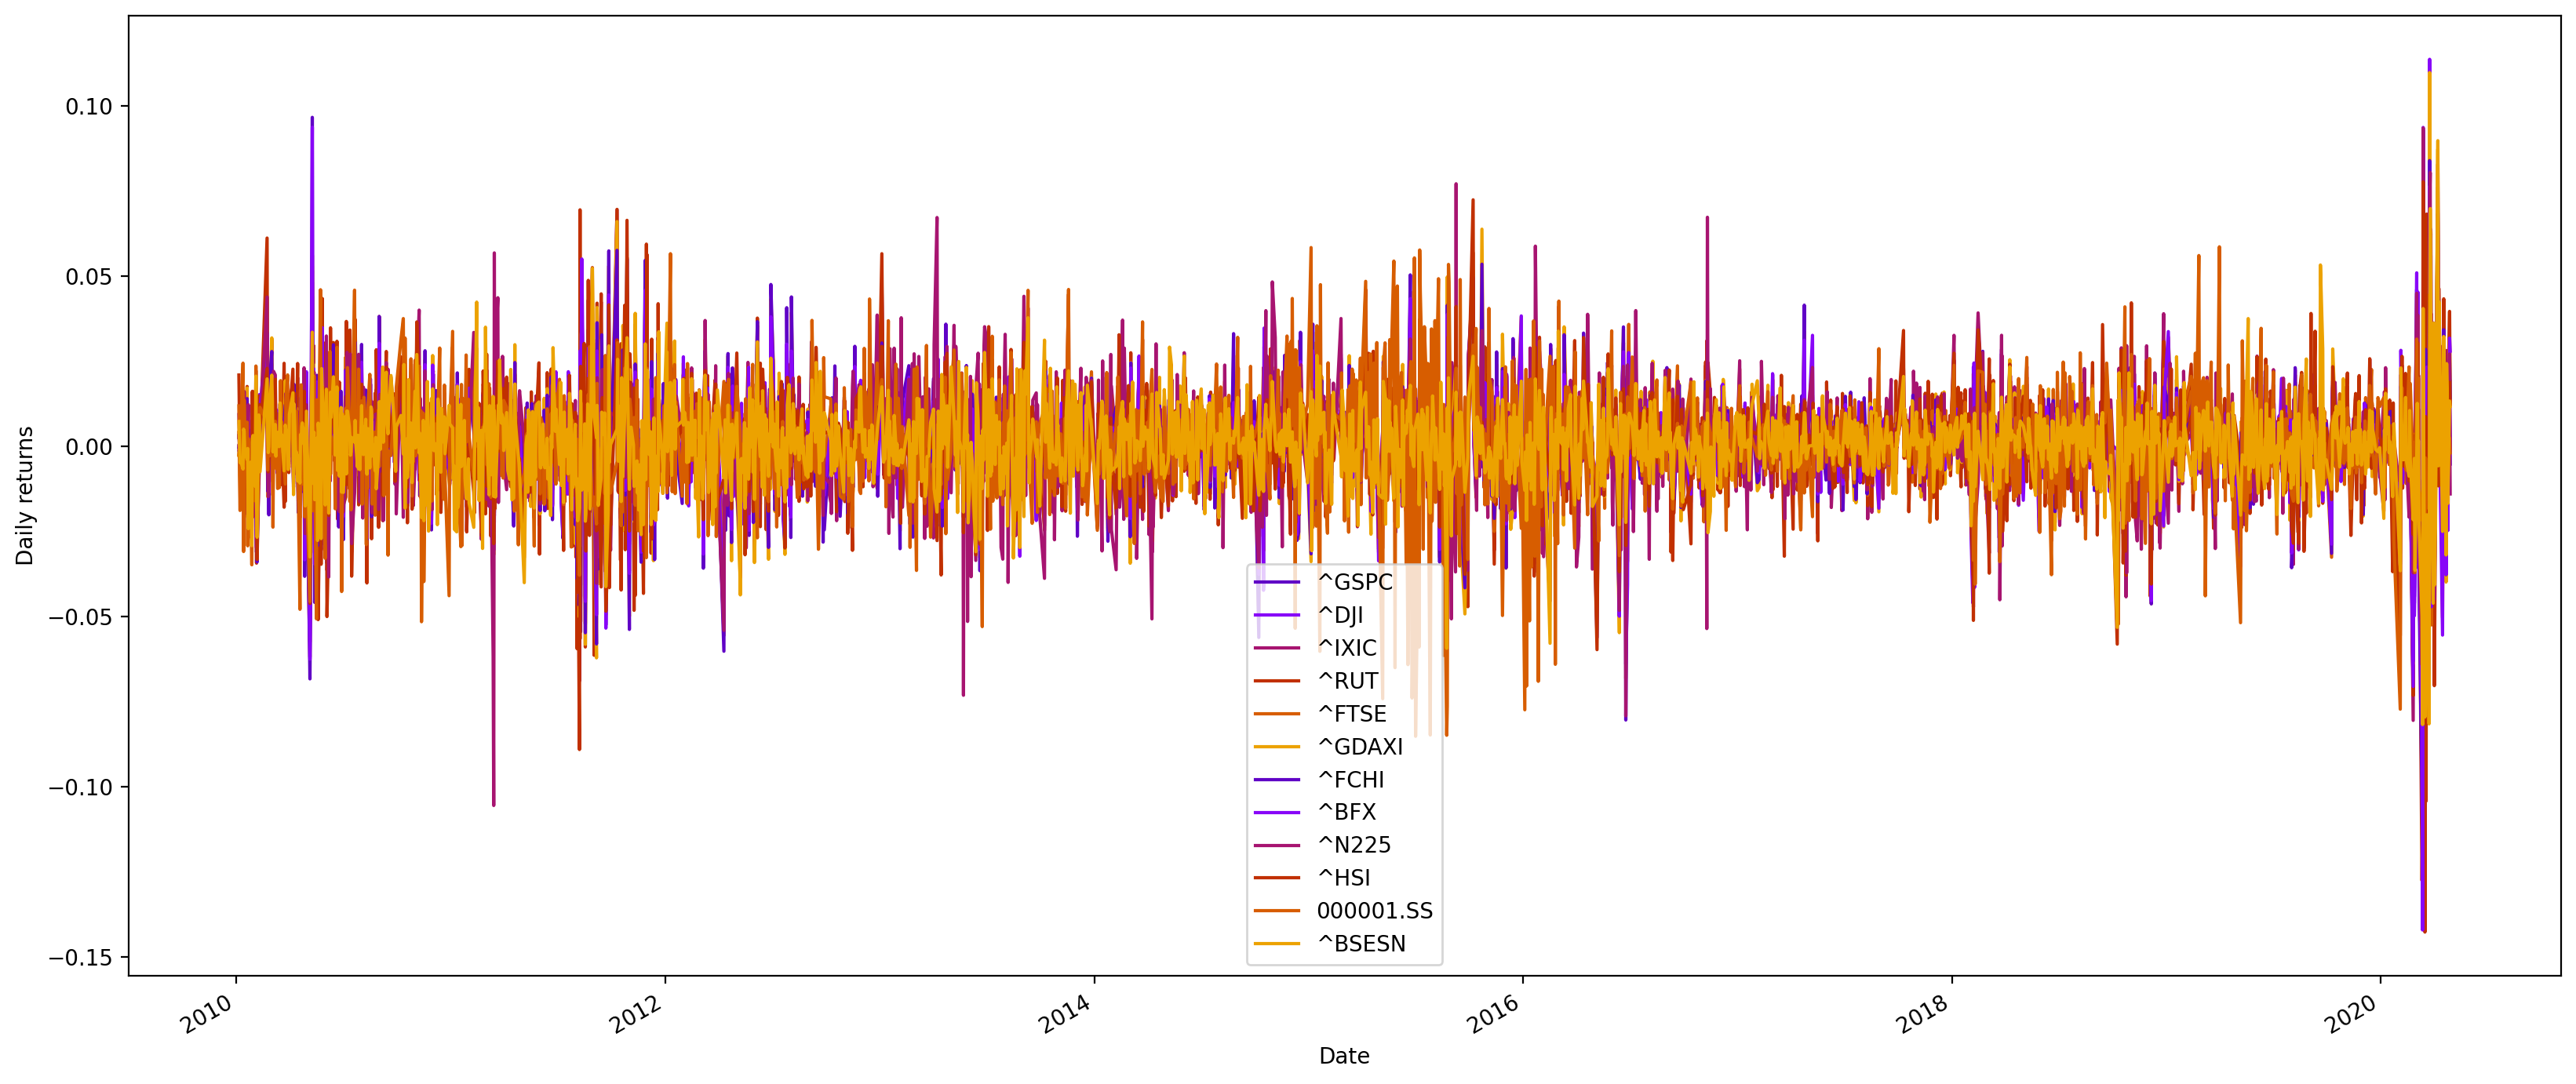

In [5]:
dataset.plot()
plt.xlabel('Date')
plt.ylabel('Daily returns')
plt.show()

# Principal Component Analysis (PCA)

Although technique more than a hundred years old (Pearson 1901), *principal component analysis* (PCA) is still being used widely today. The main idea behind it is to find the main underlying dimensions of a correlated dataset. This reduction in dimensionality can create new insights or make the dataset more manageable.

Its first step is to find the direction of maximum variance; this will be the first component. This is the direction along which all of the dataset's features are most correlated with each other. The second component is then found by again identifying a direction which correlates the most, but this time being orthagonal to the first component. This can continue on for as long as there are features. Principal components derived like this are also called *eigenvectors*.

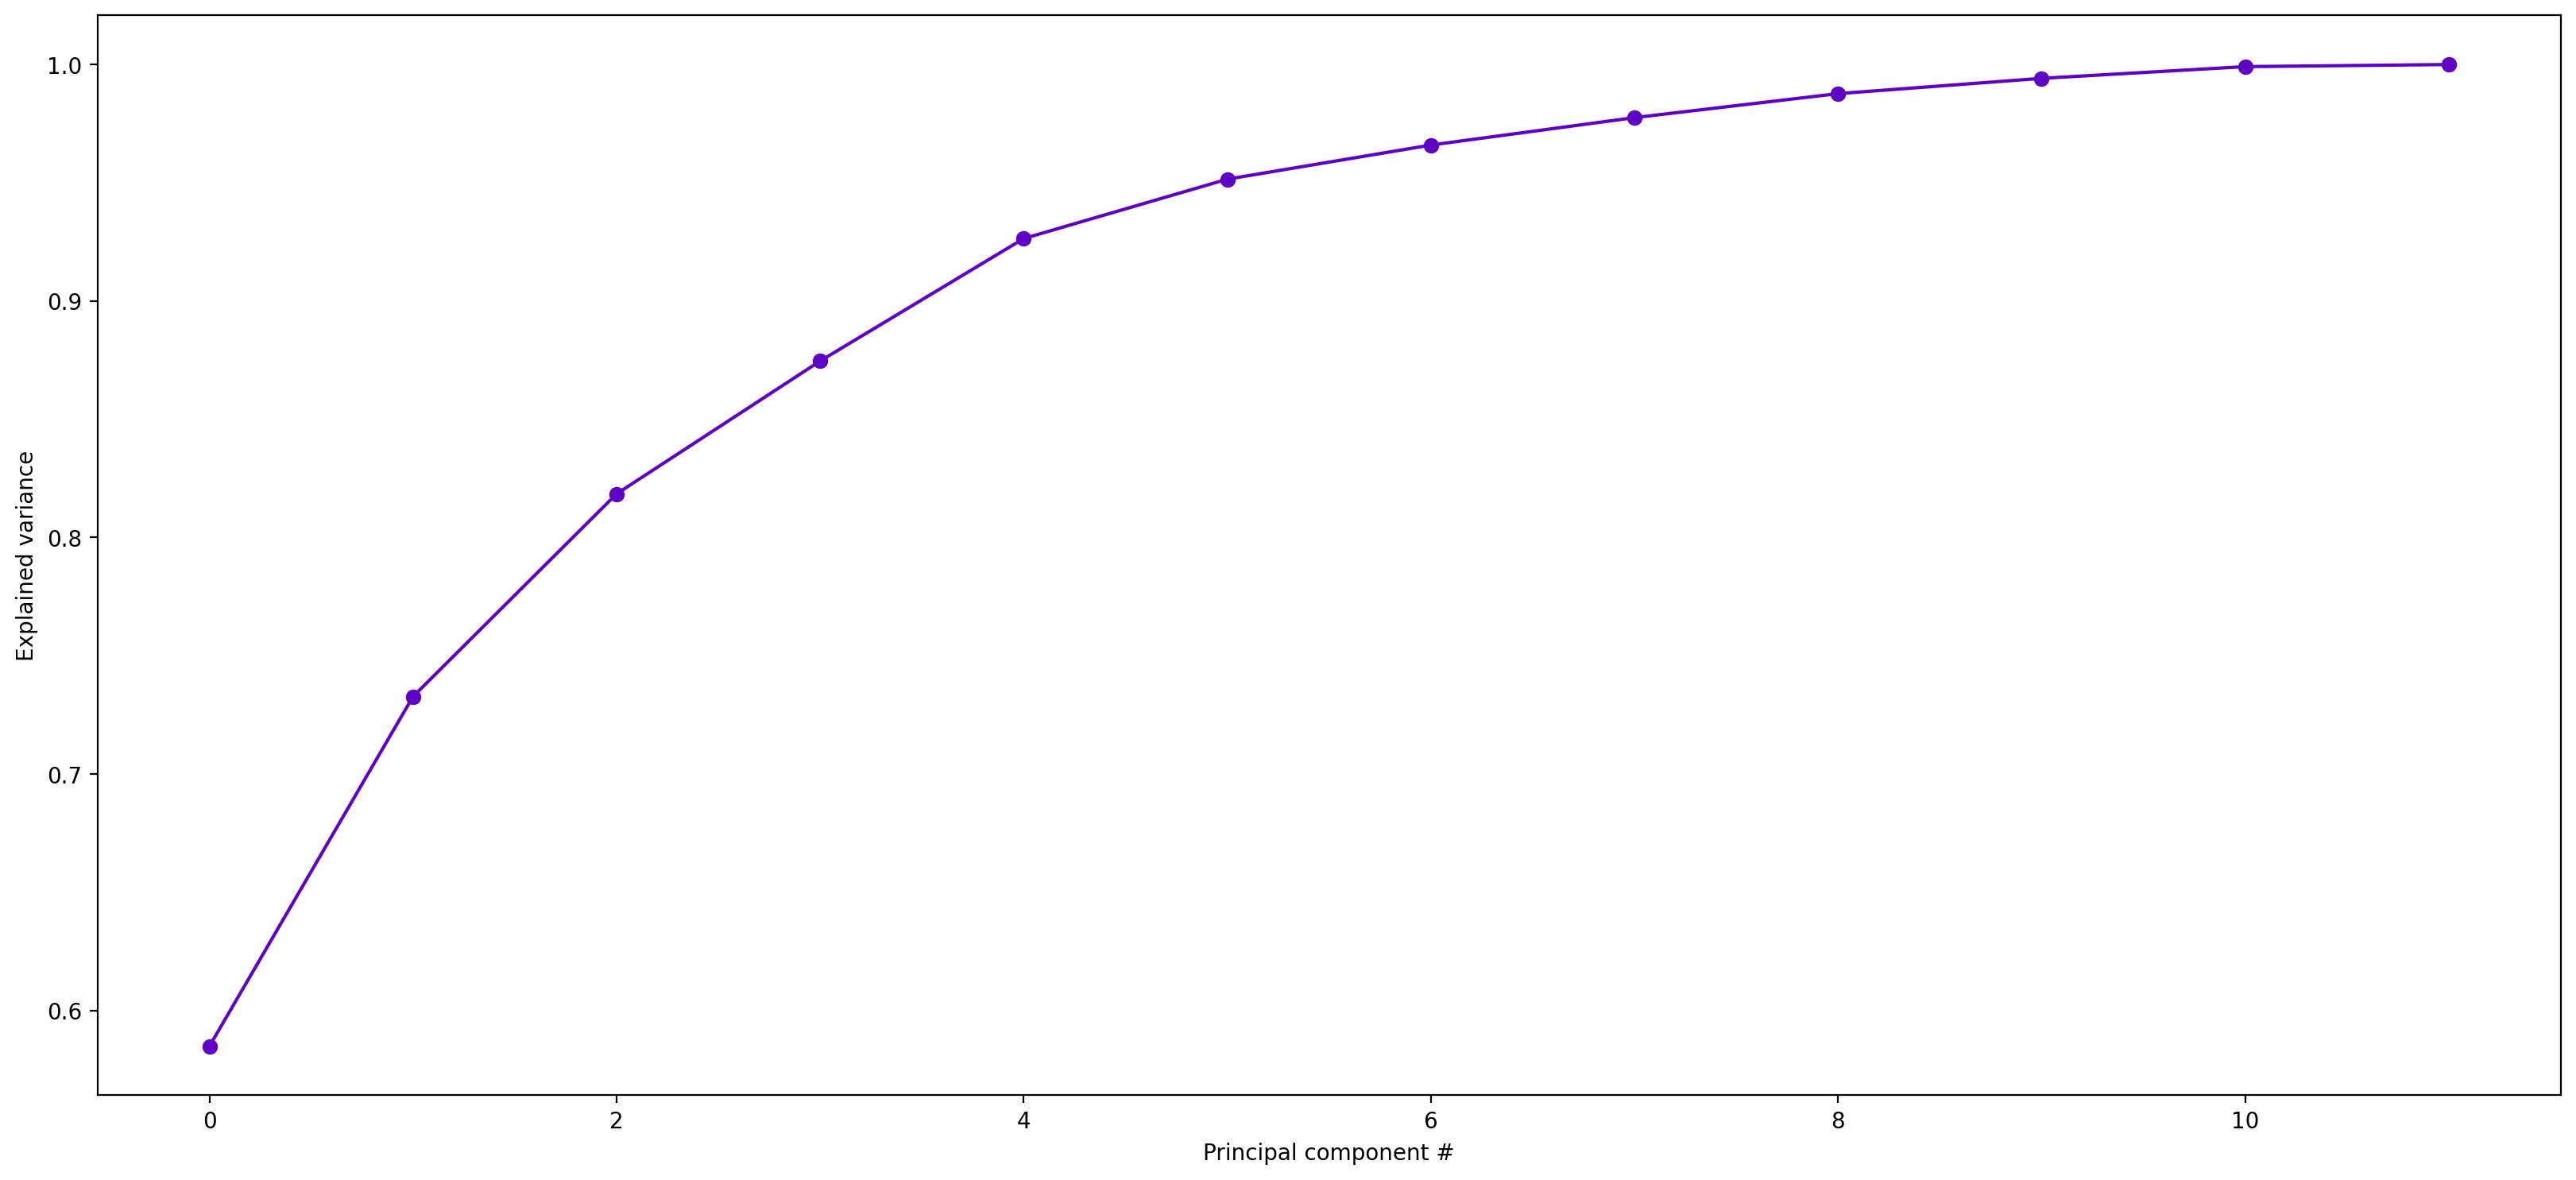

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(StandardScaler().fit_transform(dataset))
expl_var = pca.explained_variance_ratio_
pd.DataFrame(expl_var.cumsum()).plot(style='-o', legend=False)
plt.xlabel('Principal component #')
plt.ylabel('Explained variance')
plt.show()

As can be seen here, the first principal component identified by the `PCA` model is already able to explain a signifcant amount (`58,5%`) of the variance of the total dataset. By also considering the second and third components, we are already able to explain more than `80%`!

This means that we can have quite a good idea of what our portfolio is doing without having to keep track of all of the original (twelve) assets.

Let's take a look at a possible interpretation of these components.

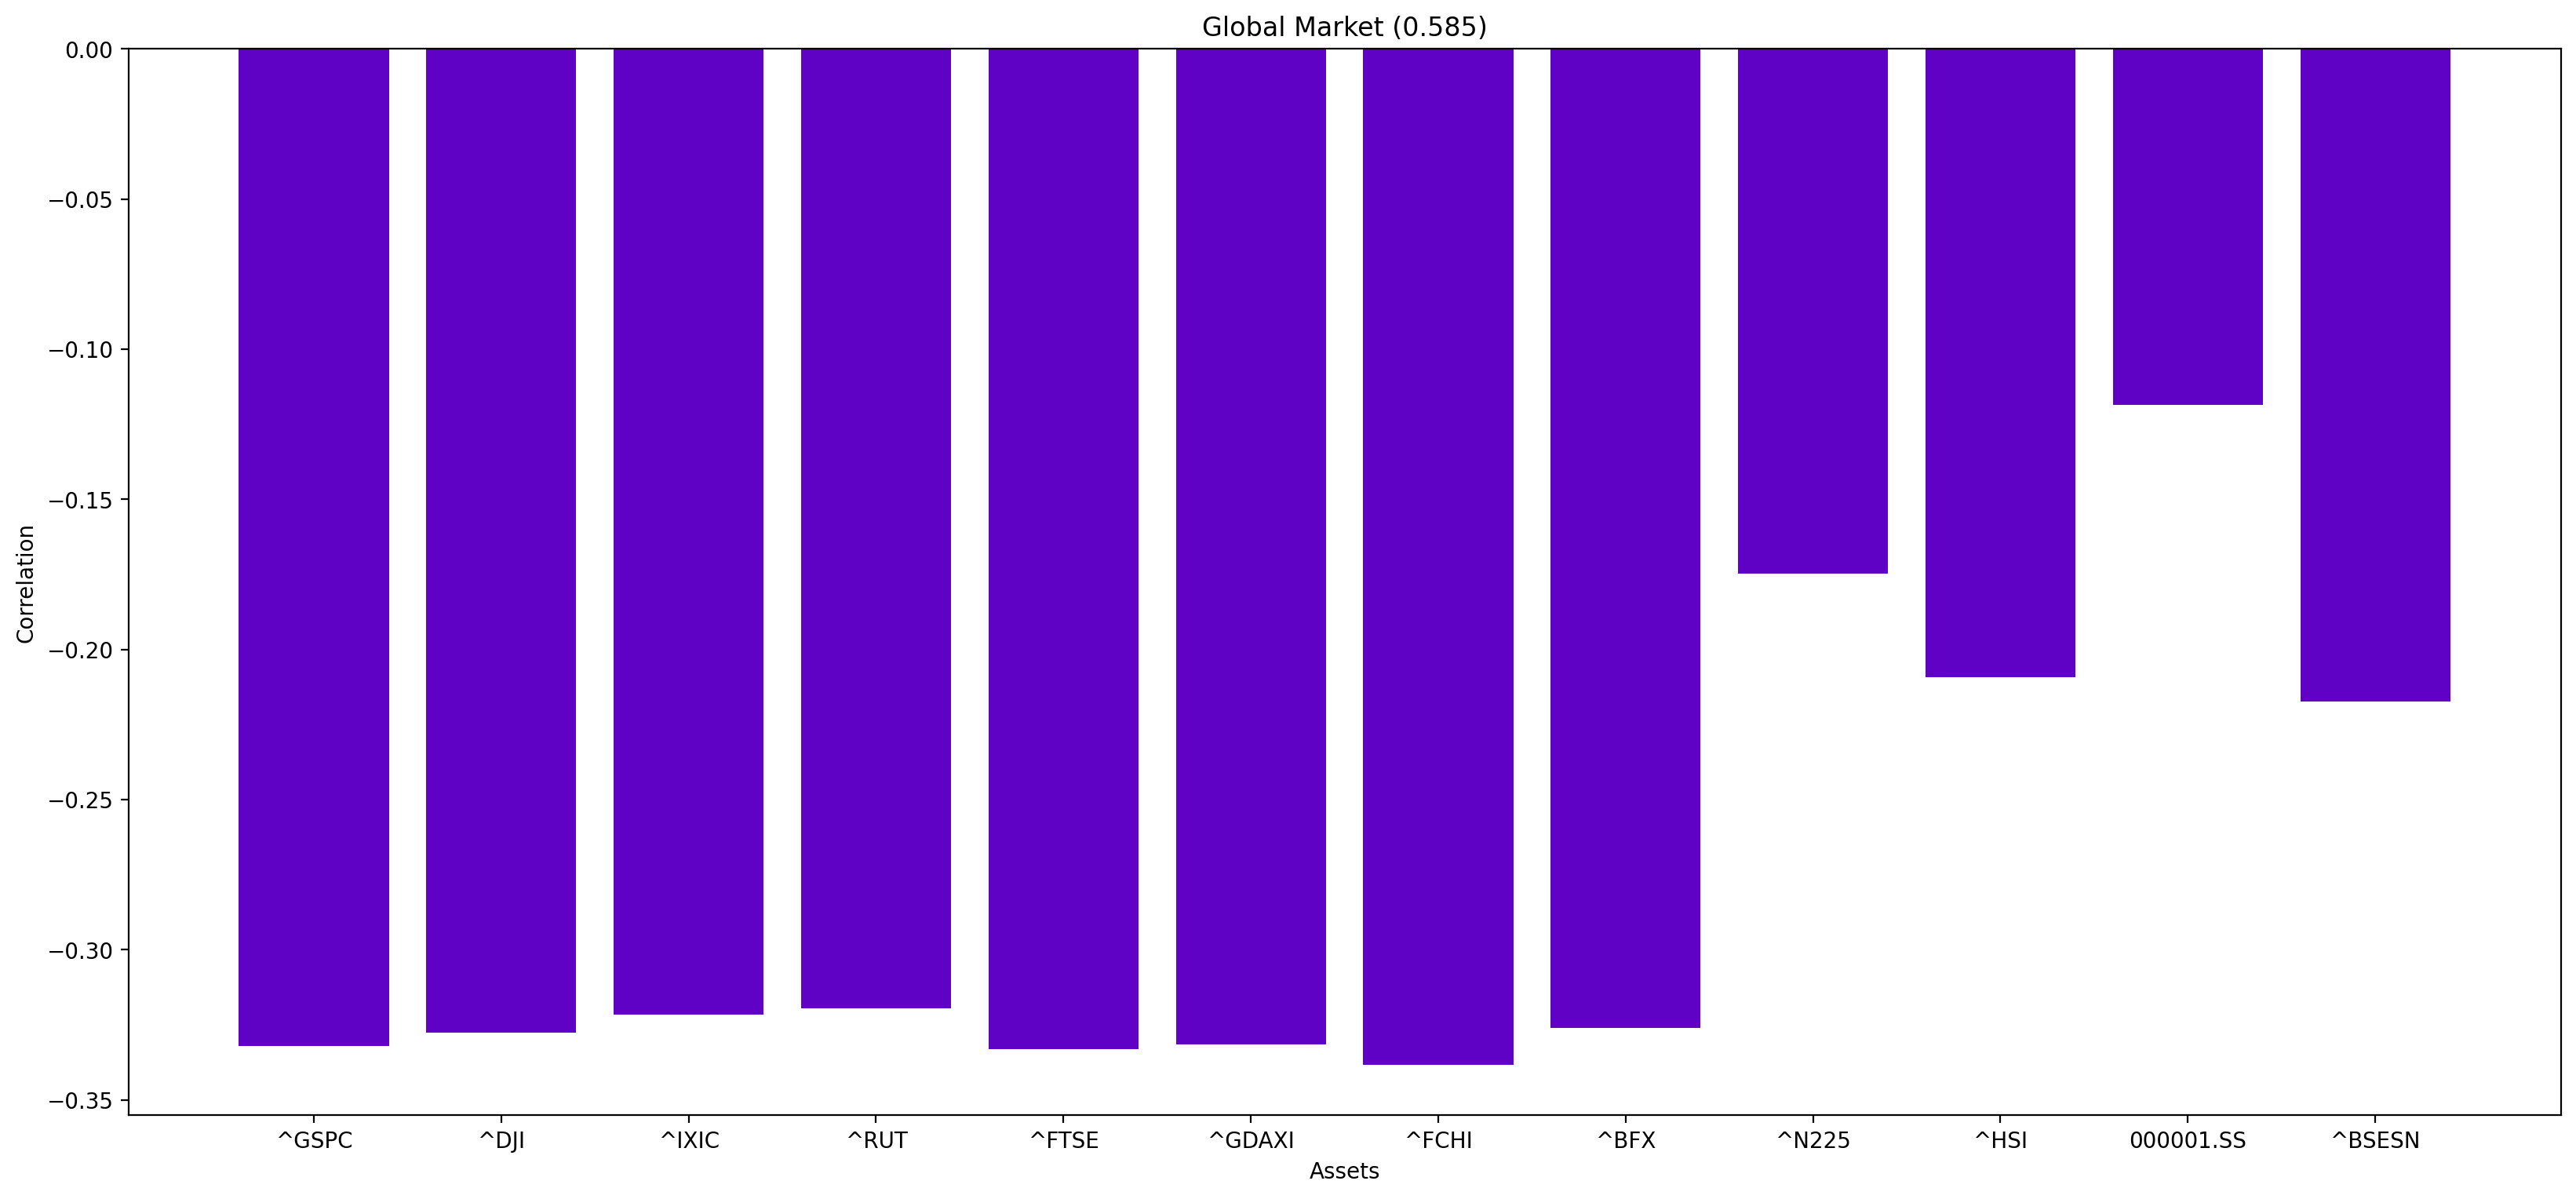

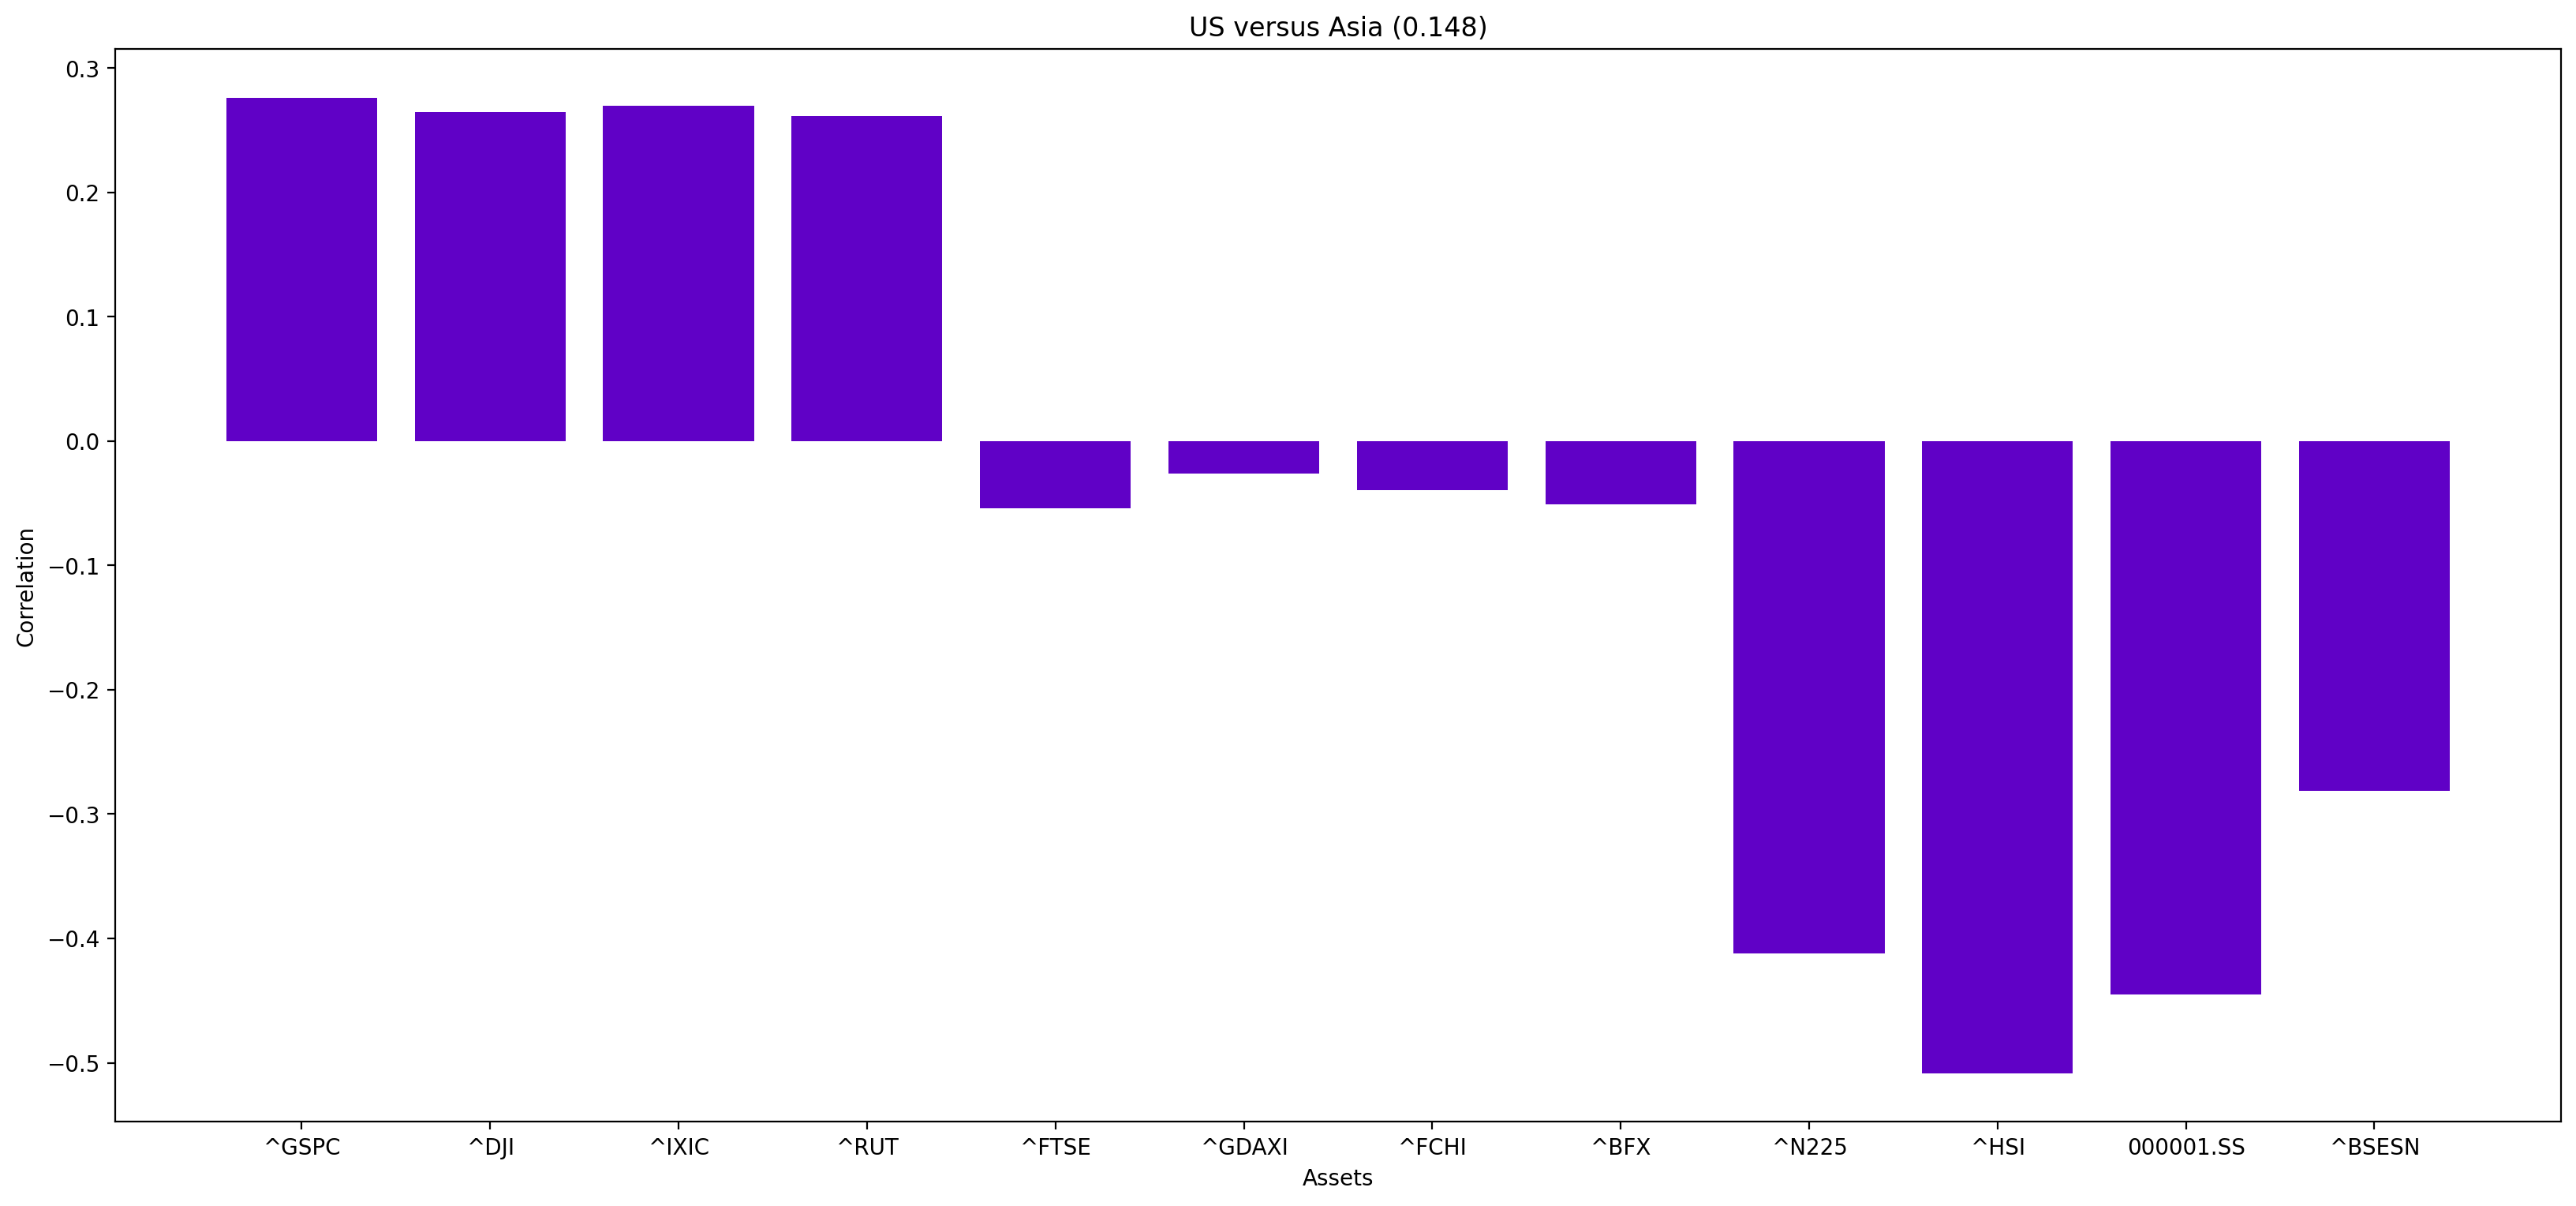

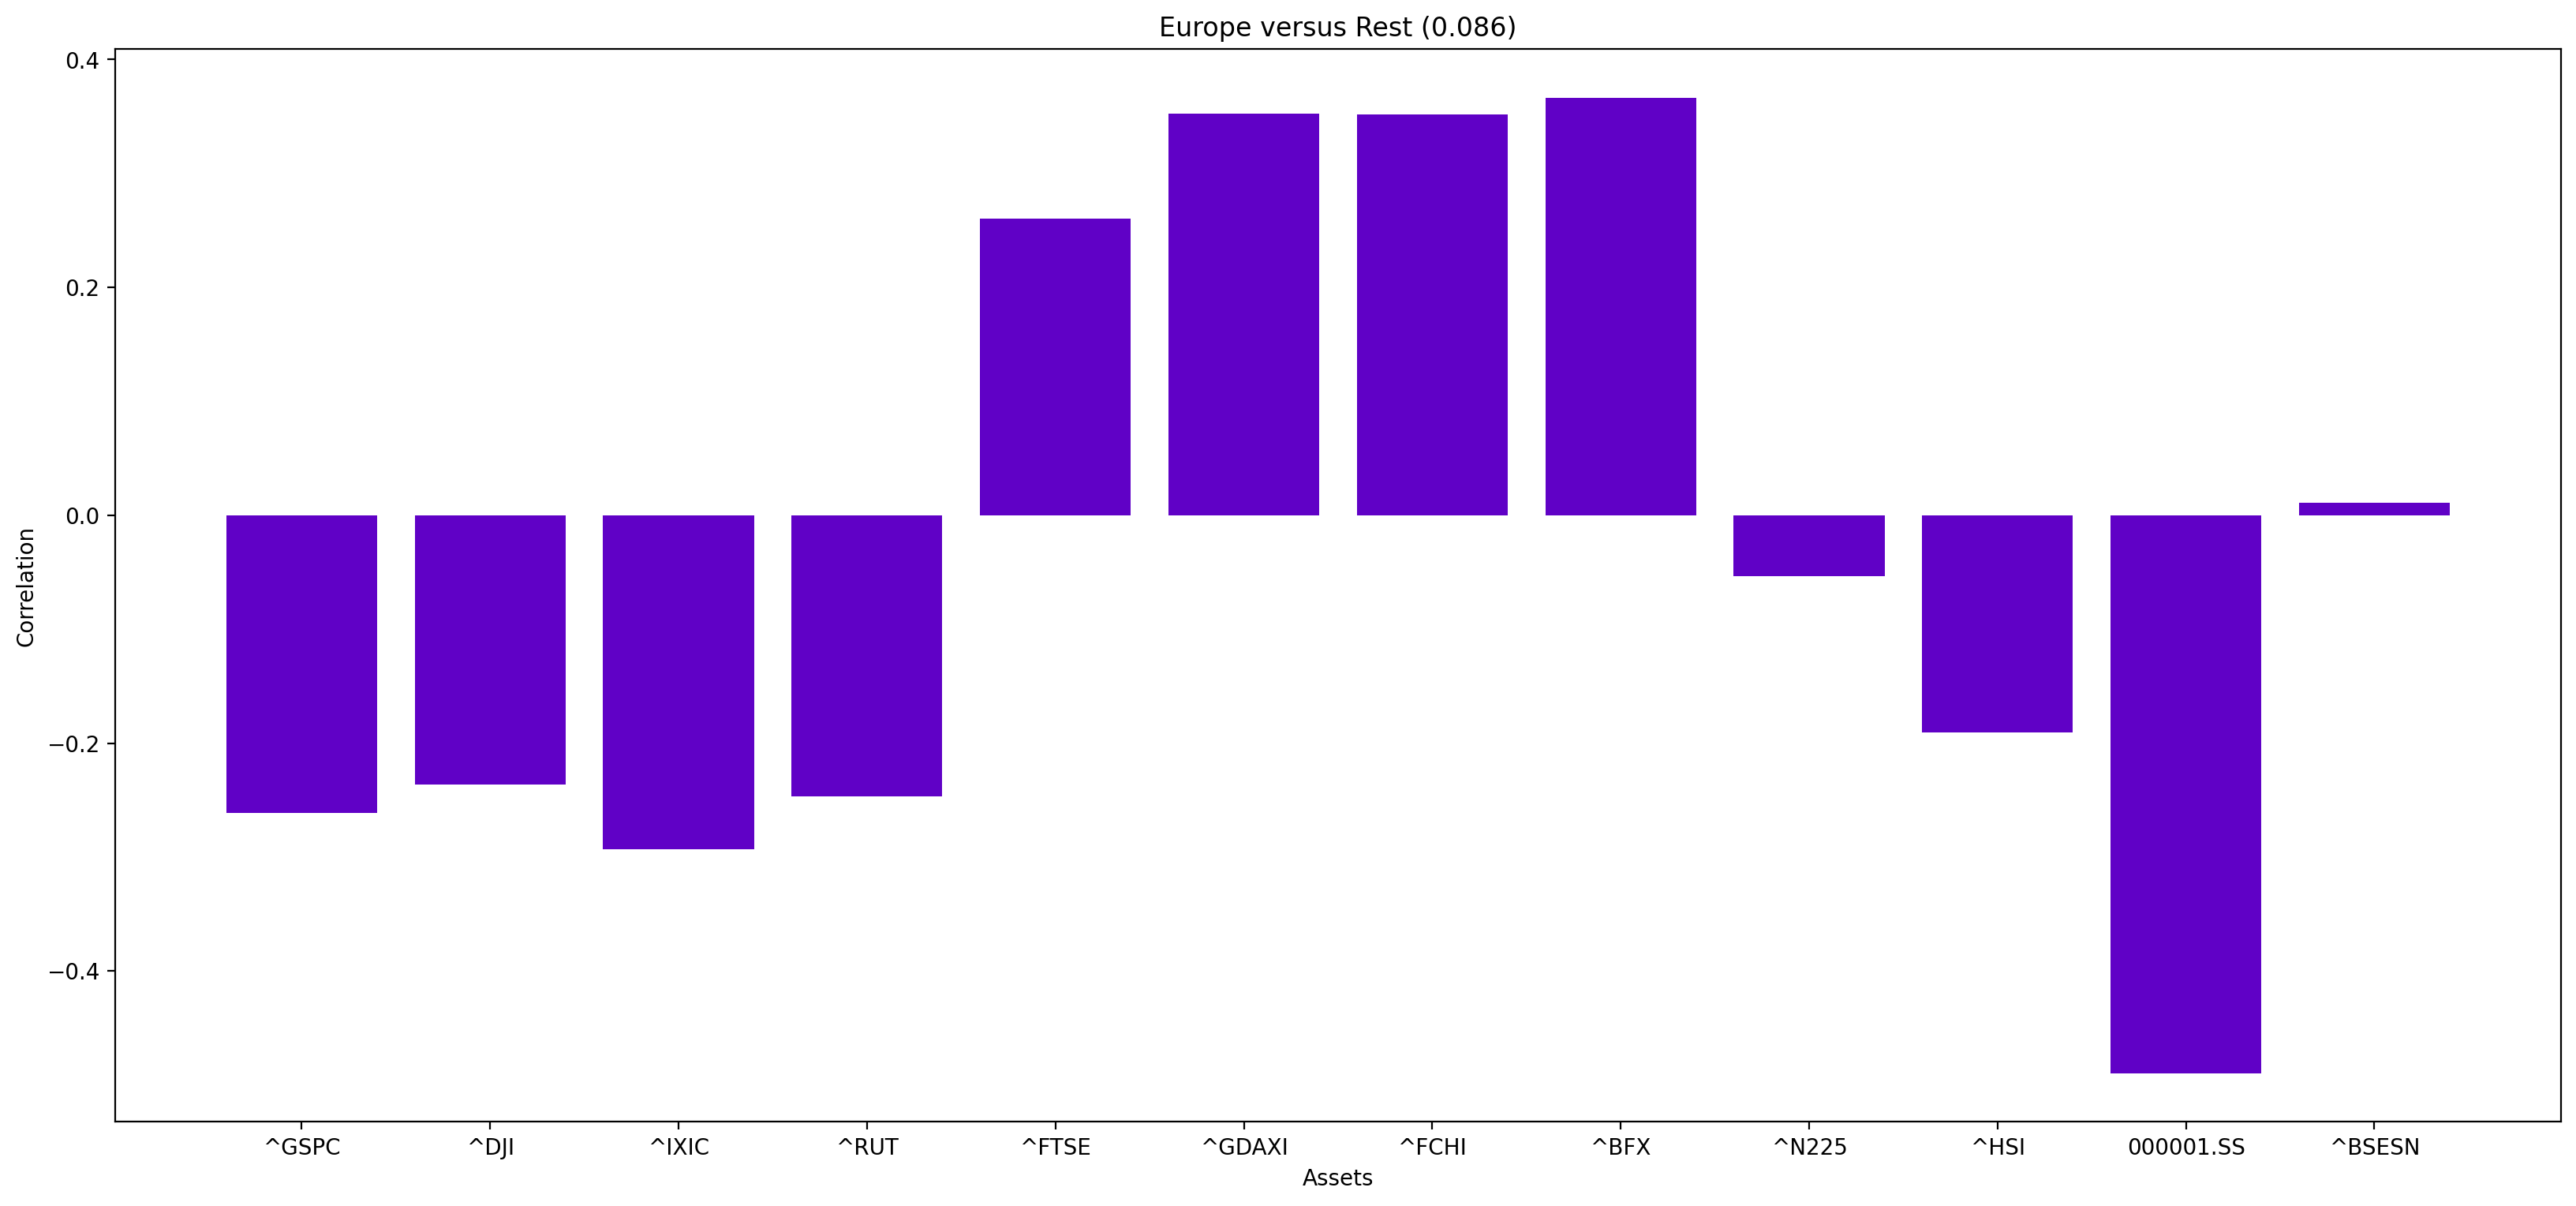

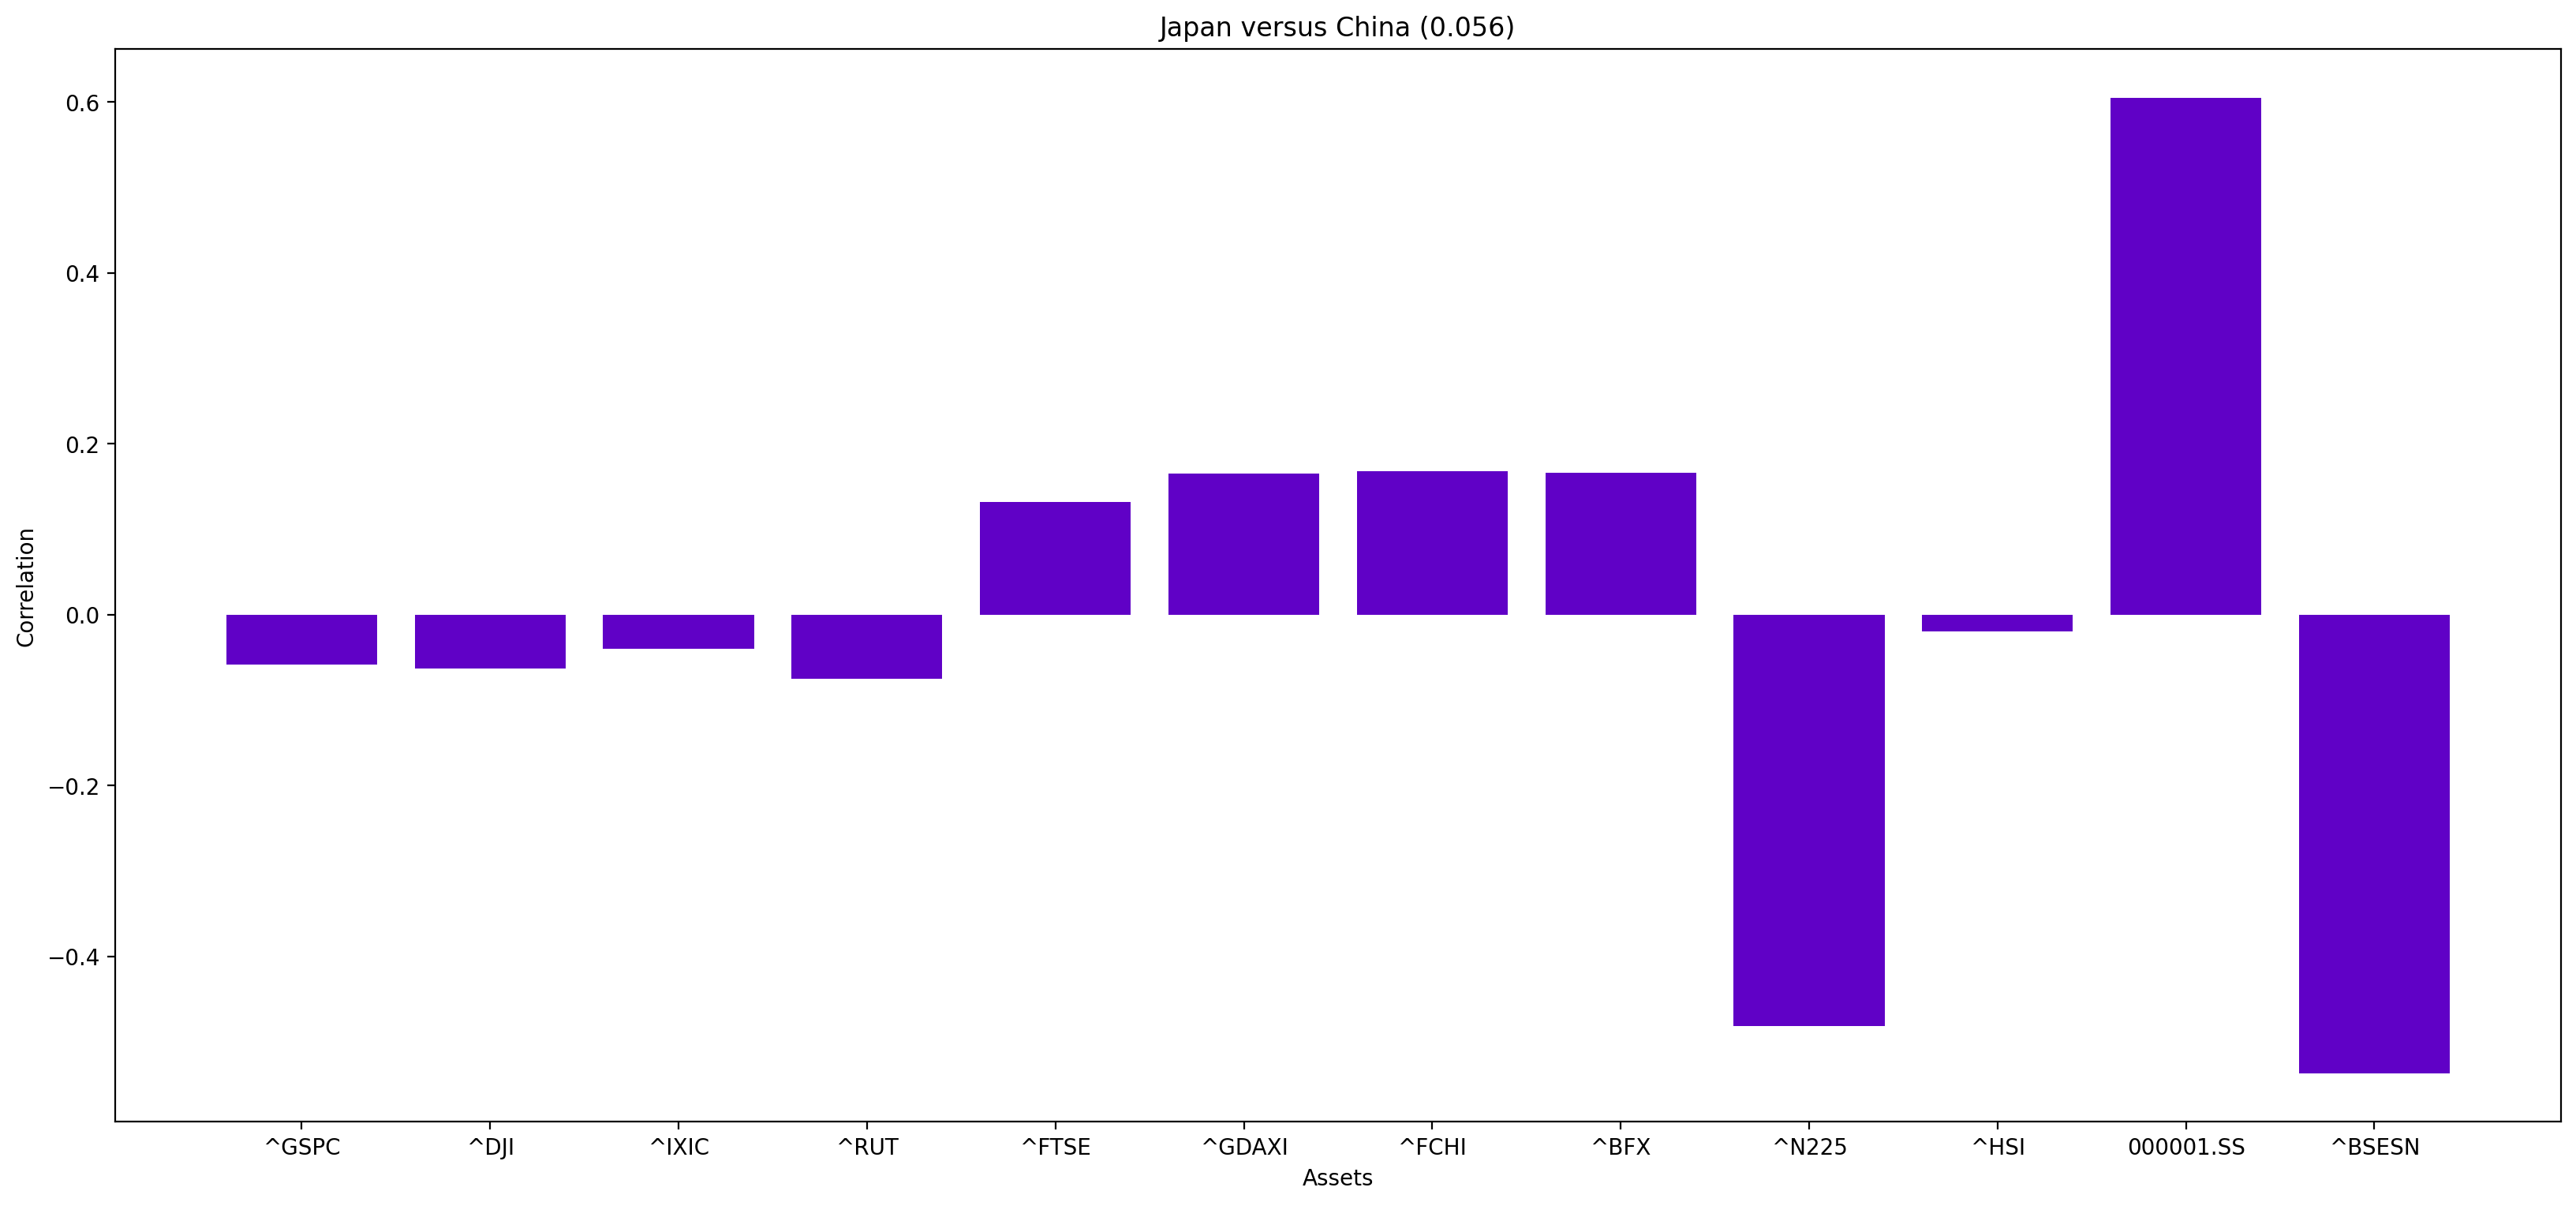

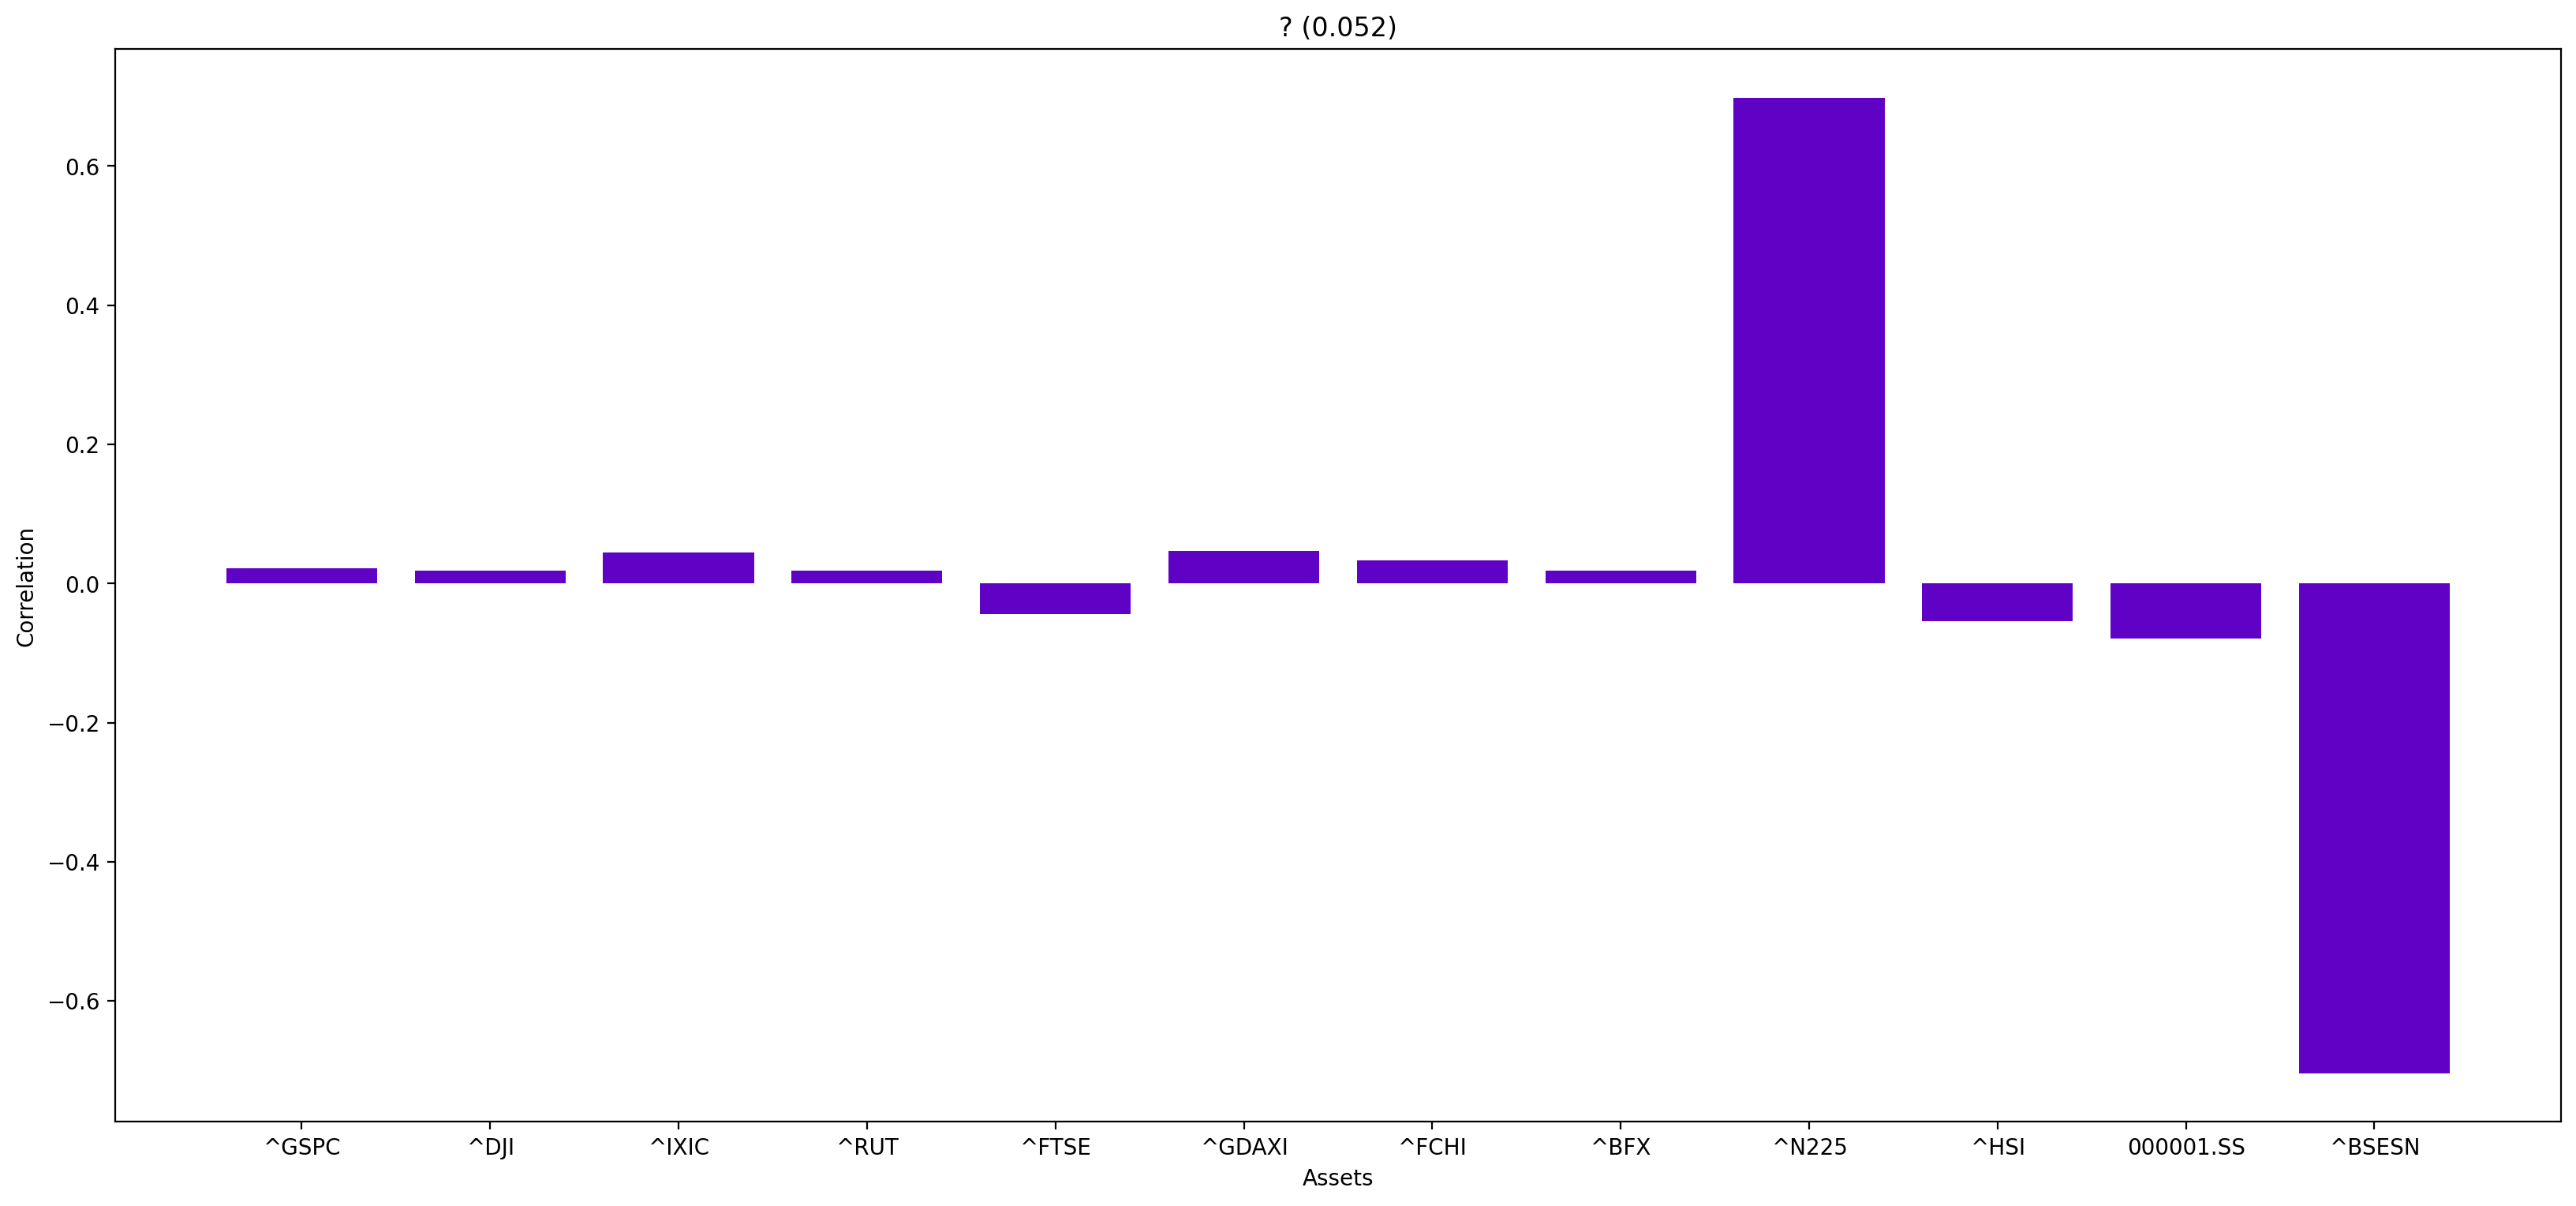

In [7]:
component_labels = {
    0: f'Global Market ({round(expl_var[0], 3)})',
    1: f'US versus Asia ({round(expl_var[1], 3)})',
    2: f'Europe versus Rest ({round(expl_var[2], 3)})',
    3: f'Japan versus China ({round(expl_var[3], 3)})',
    4: f'? ({round(expl_var[4], 3)})'
}

for n, component in enumerate(pca.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xticks(dataset.columns)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

The first component is a general one; all indices correlate negatively with it. Basically this means that there is a direction in the data along which all the indices move together. We can label this direction as the global economy as a whole; all these markets share some form of dependency.

The second component shows positive correlation for *all* American indices and a negative correlation for *all* Asian indices. This opposition means that American markets go up when Asian markets go down and vice versa. It is interesting to note that European markets barely correlate with this dimension; i.e. they are independent of these market movements.

The third biggest component does involve European markets, and basically shows a negative correlation with the all of the other indices. Contrary to what we saw in the second component, in this component American and Asian markets do move together.

Not all components can be interpreted this clearly though. The fourth still allows for some interpretation but this becomes more difficult for the fifth. Bear in mind that these components also start to matter less and less; the fifth component only explains `5,2%` of the dataset's total variance whereas the first does so for `58,5%`.

Finally we want to determine how many components we actually need. One could apply an arbitrary threshold such as `80%` or look at the cumulative explained variance plot and determine where the 'elbow' is. However, instead we choose a method which requires the eigenvector's *eigenvalue* to be `> 1`. It should be noted no single method has been proven to be the best and they can all give different results. For a thorough review of various methods see Cangelosi (2007).

In [8]:
pd.DataFrame({
    'Eigenvalues': pca.explained_variance_, 
    'Retain?': pca.explained_variance_ > 1,
    'Explained Variance': expl_var,
    'Cumulative Expl. Var.': expl_var.cumsum()
})

Eigenvalues  Retain?  Explained Variance  Cumulative Expl. Var.
0      7.021576     True            0.584853               0.584853
1      1.775329     True            0.147874               0.732727
2      1.029014     True            0.085710               0.818437
3      0.674560    False            0.056187               0.874624
4      0.621712    False            0.051785               0.926409
5      0.301404    False            0.025105               0.951514
6      0.173352    False            0.014439               0.965953
7      0.139188    False            0.011593               0.977546
8      0.121848    False            0.010149               0.987695
9      0.077626    False            0.006466               0.994161
10     0.059476    False            0.004954               0.999115
11     0.010623    False            0.000885               1.000000

# Factor Analysis

*Factor analysis* (FA) differs from PCA for one in the fact that it loosens the requirement of components having an orthagonal rotation between them. This can allow for a single component to explain even more variance then the eigenvectors derived from PCA. Another big difference is the fact that FA only considers the common variance.

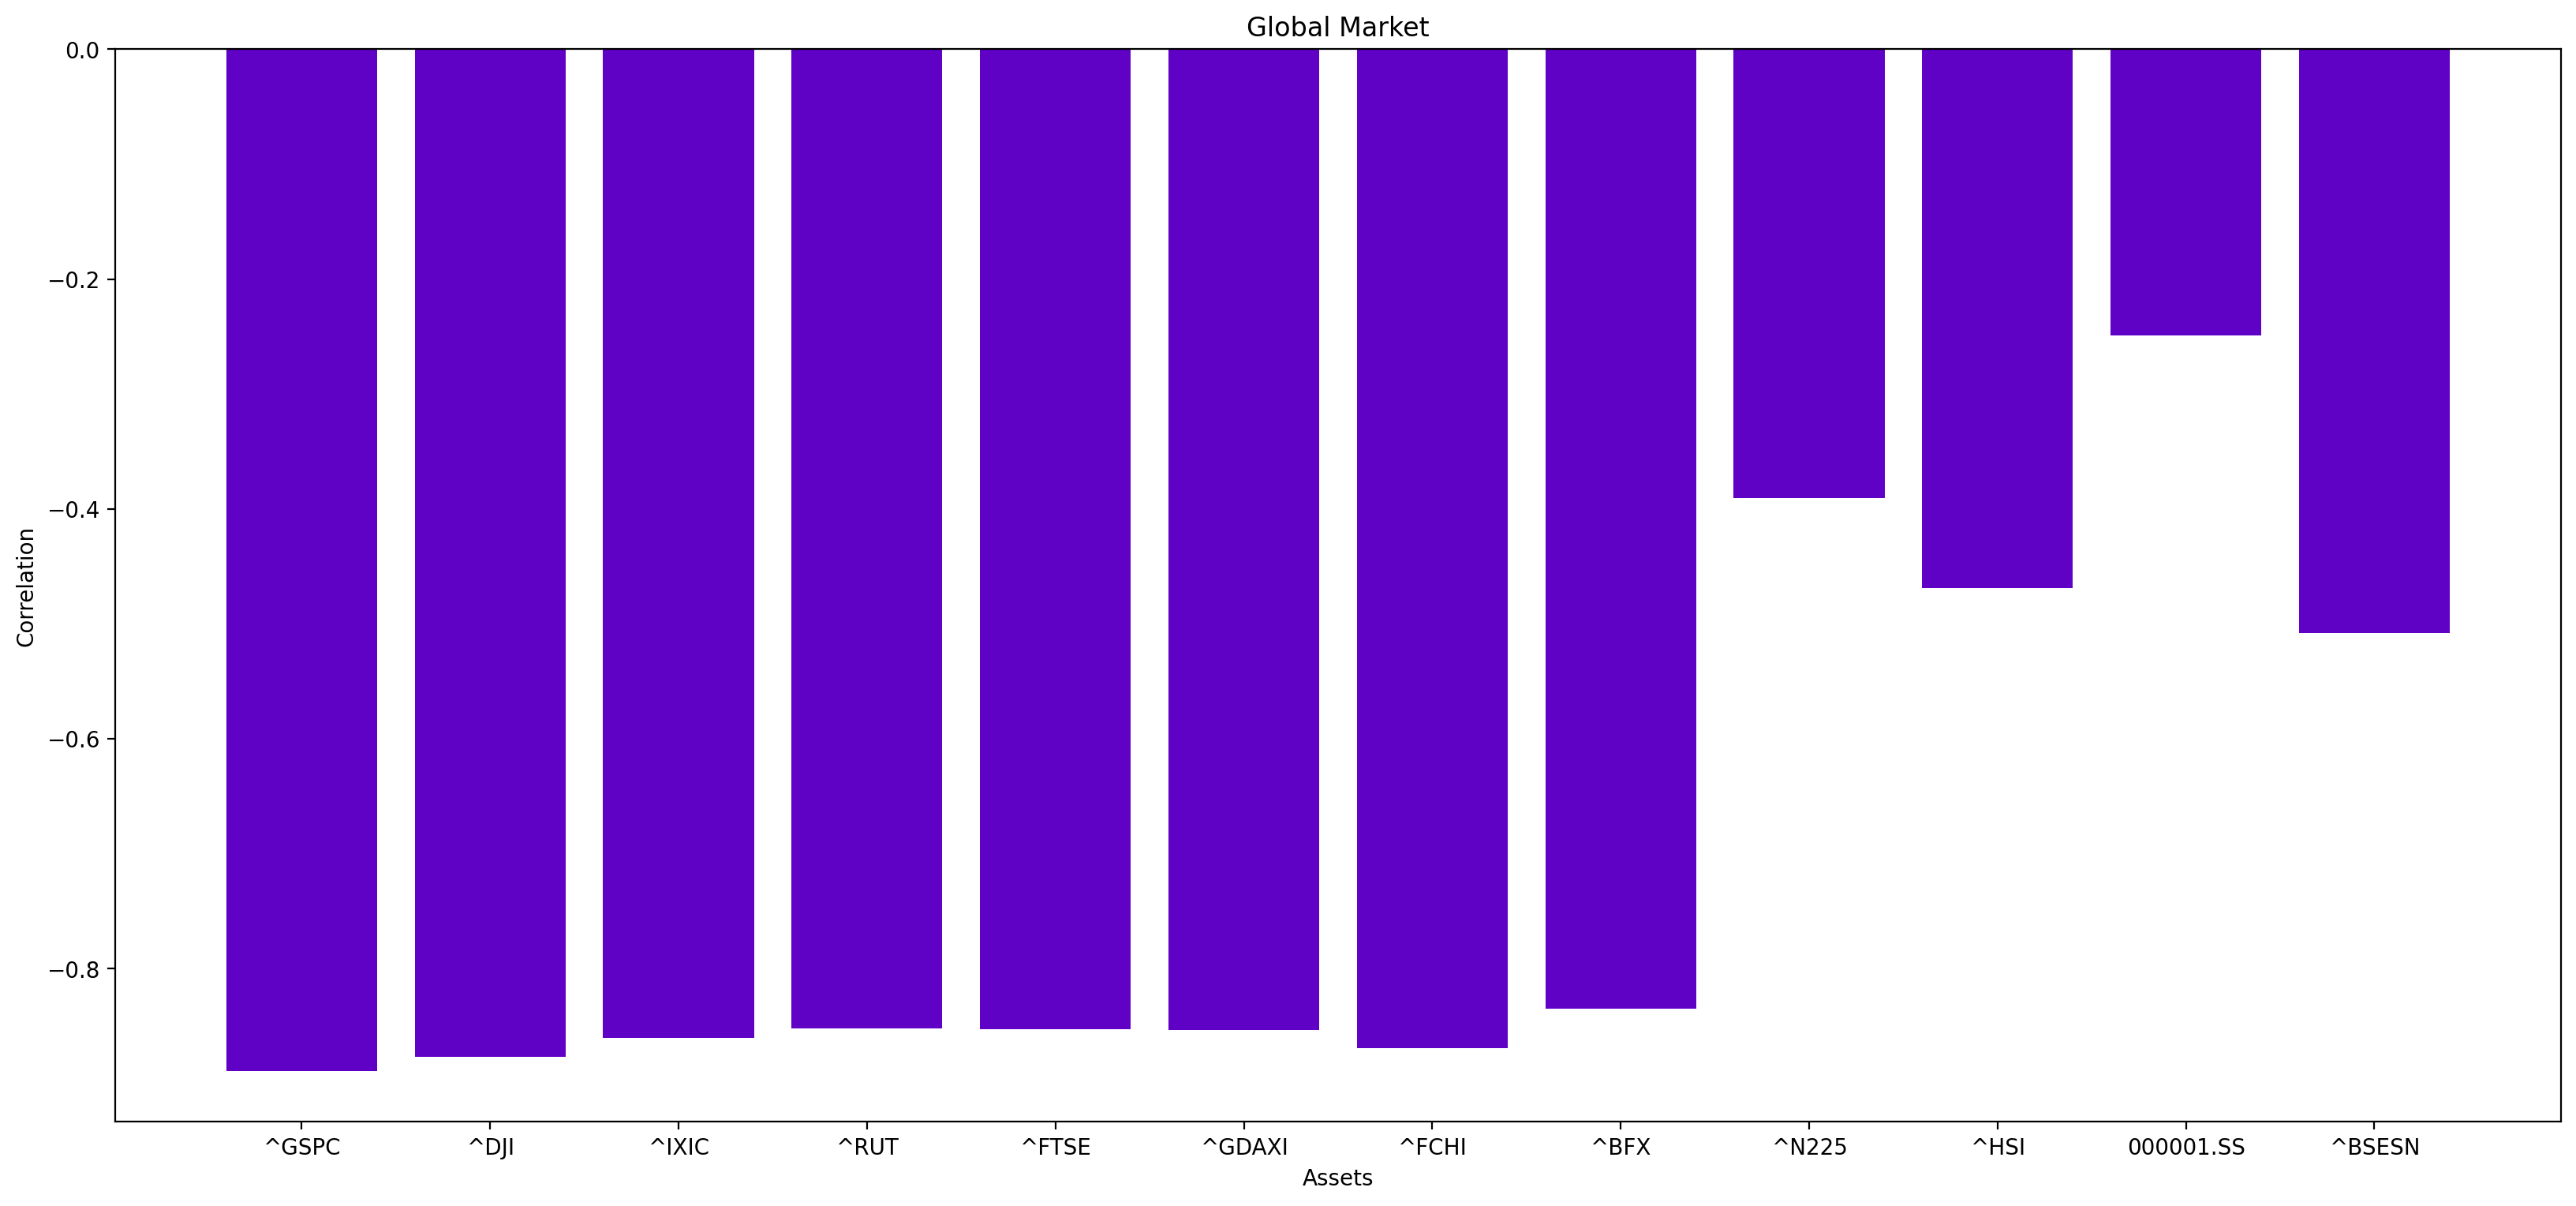

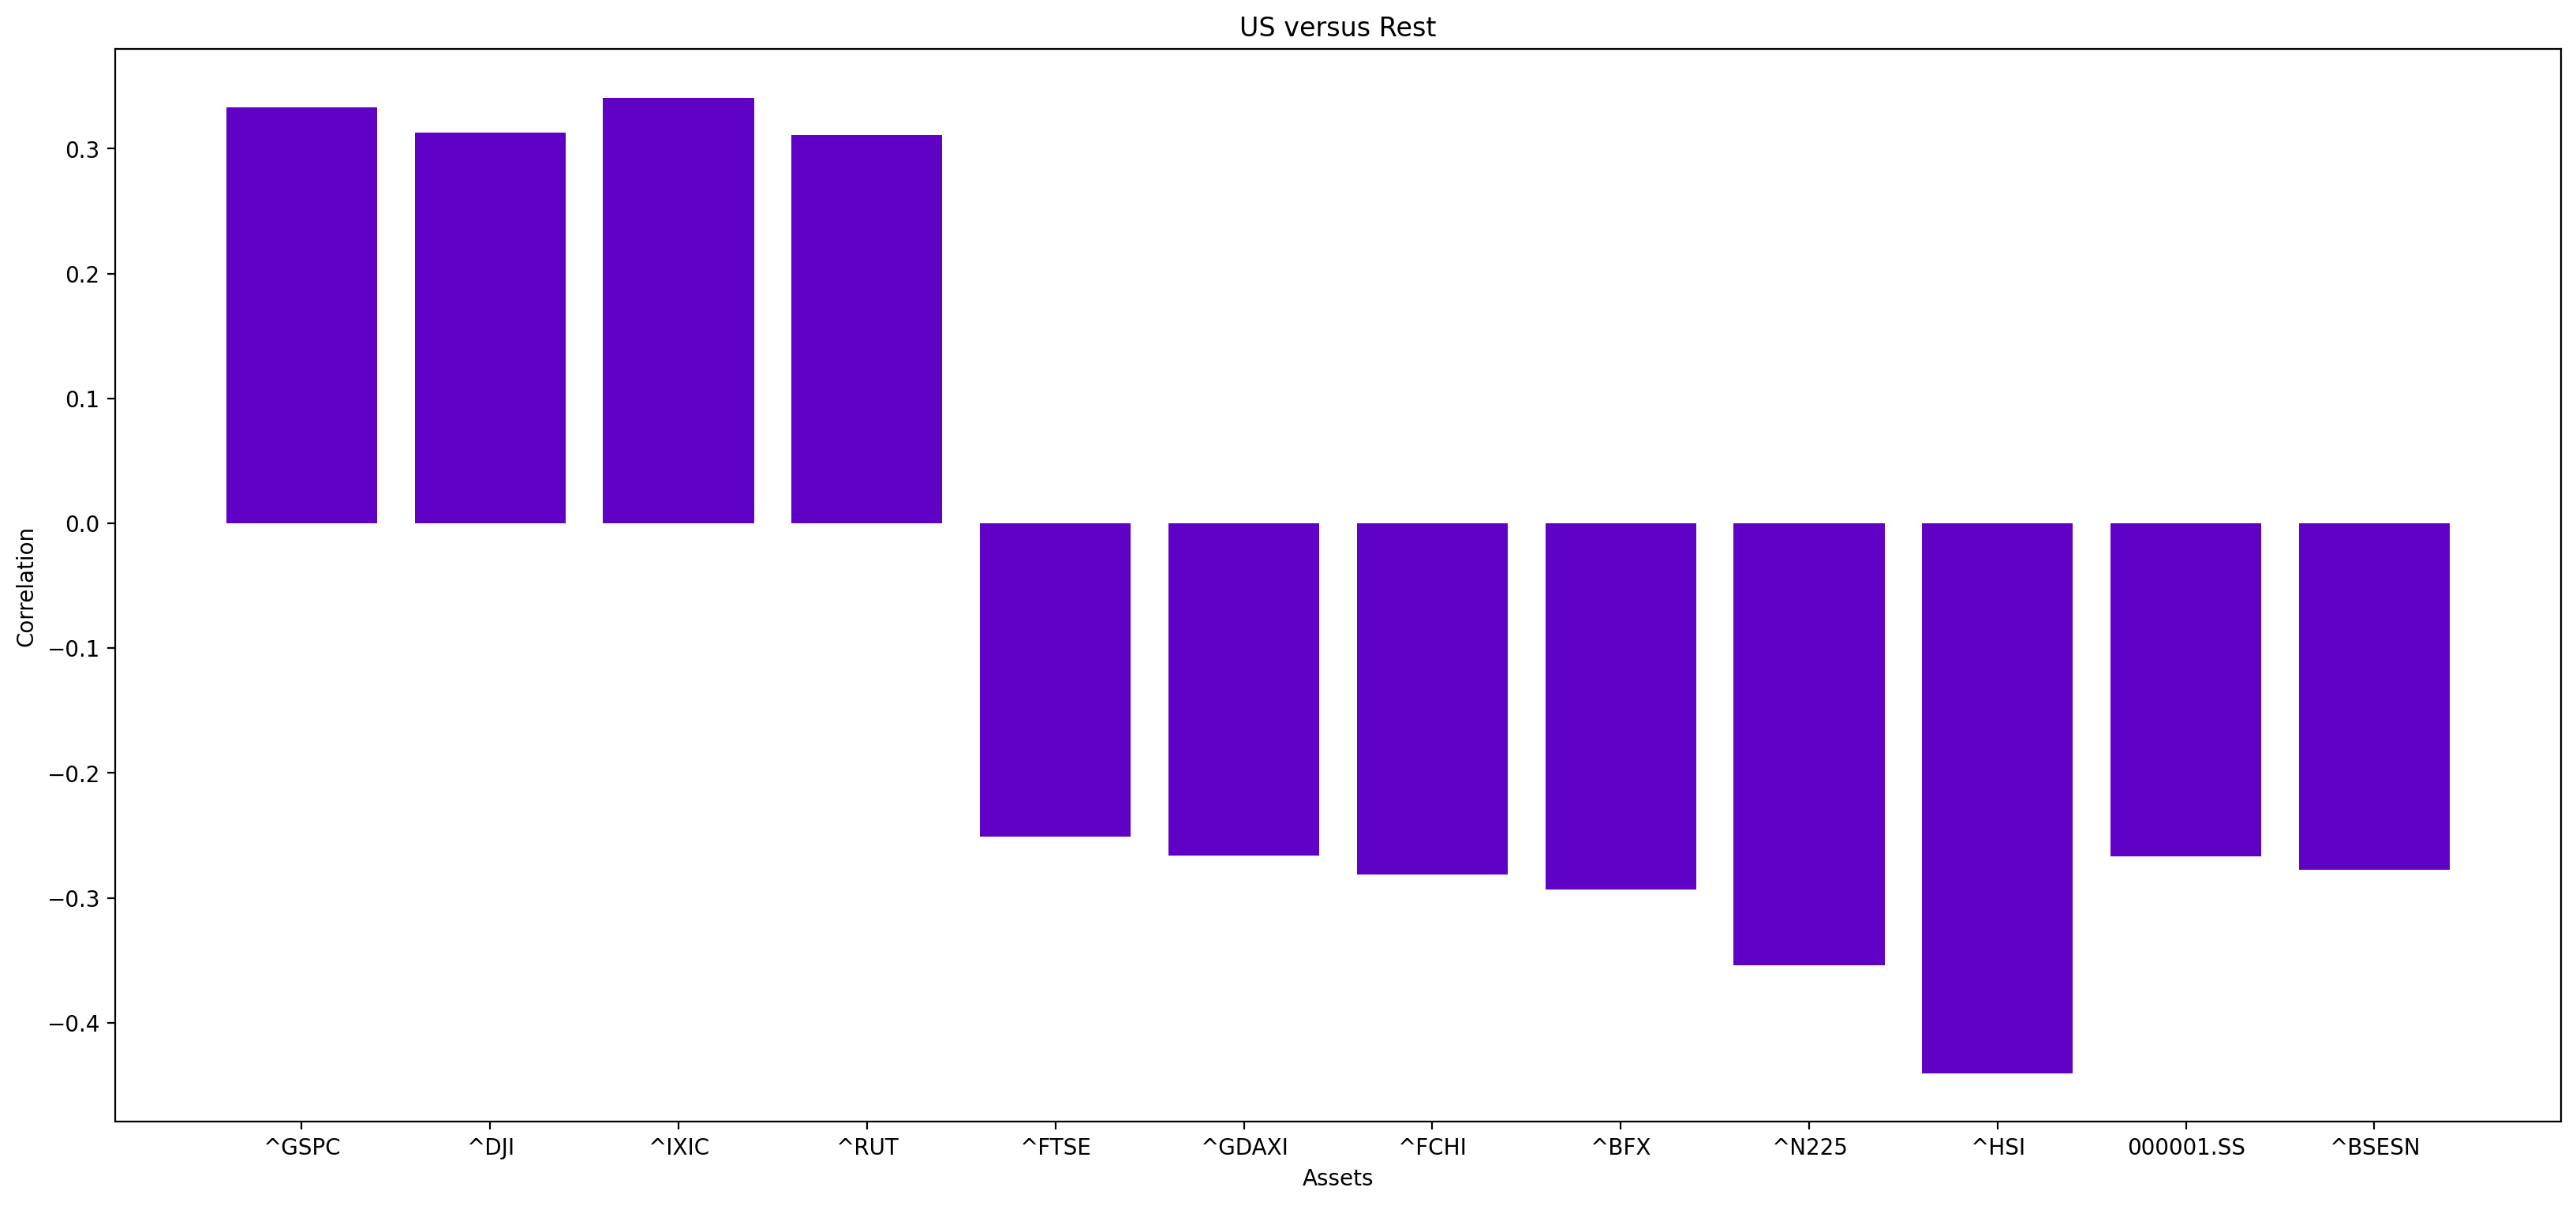

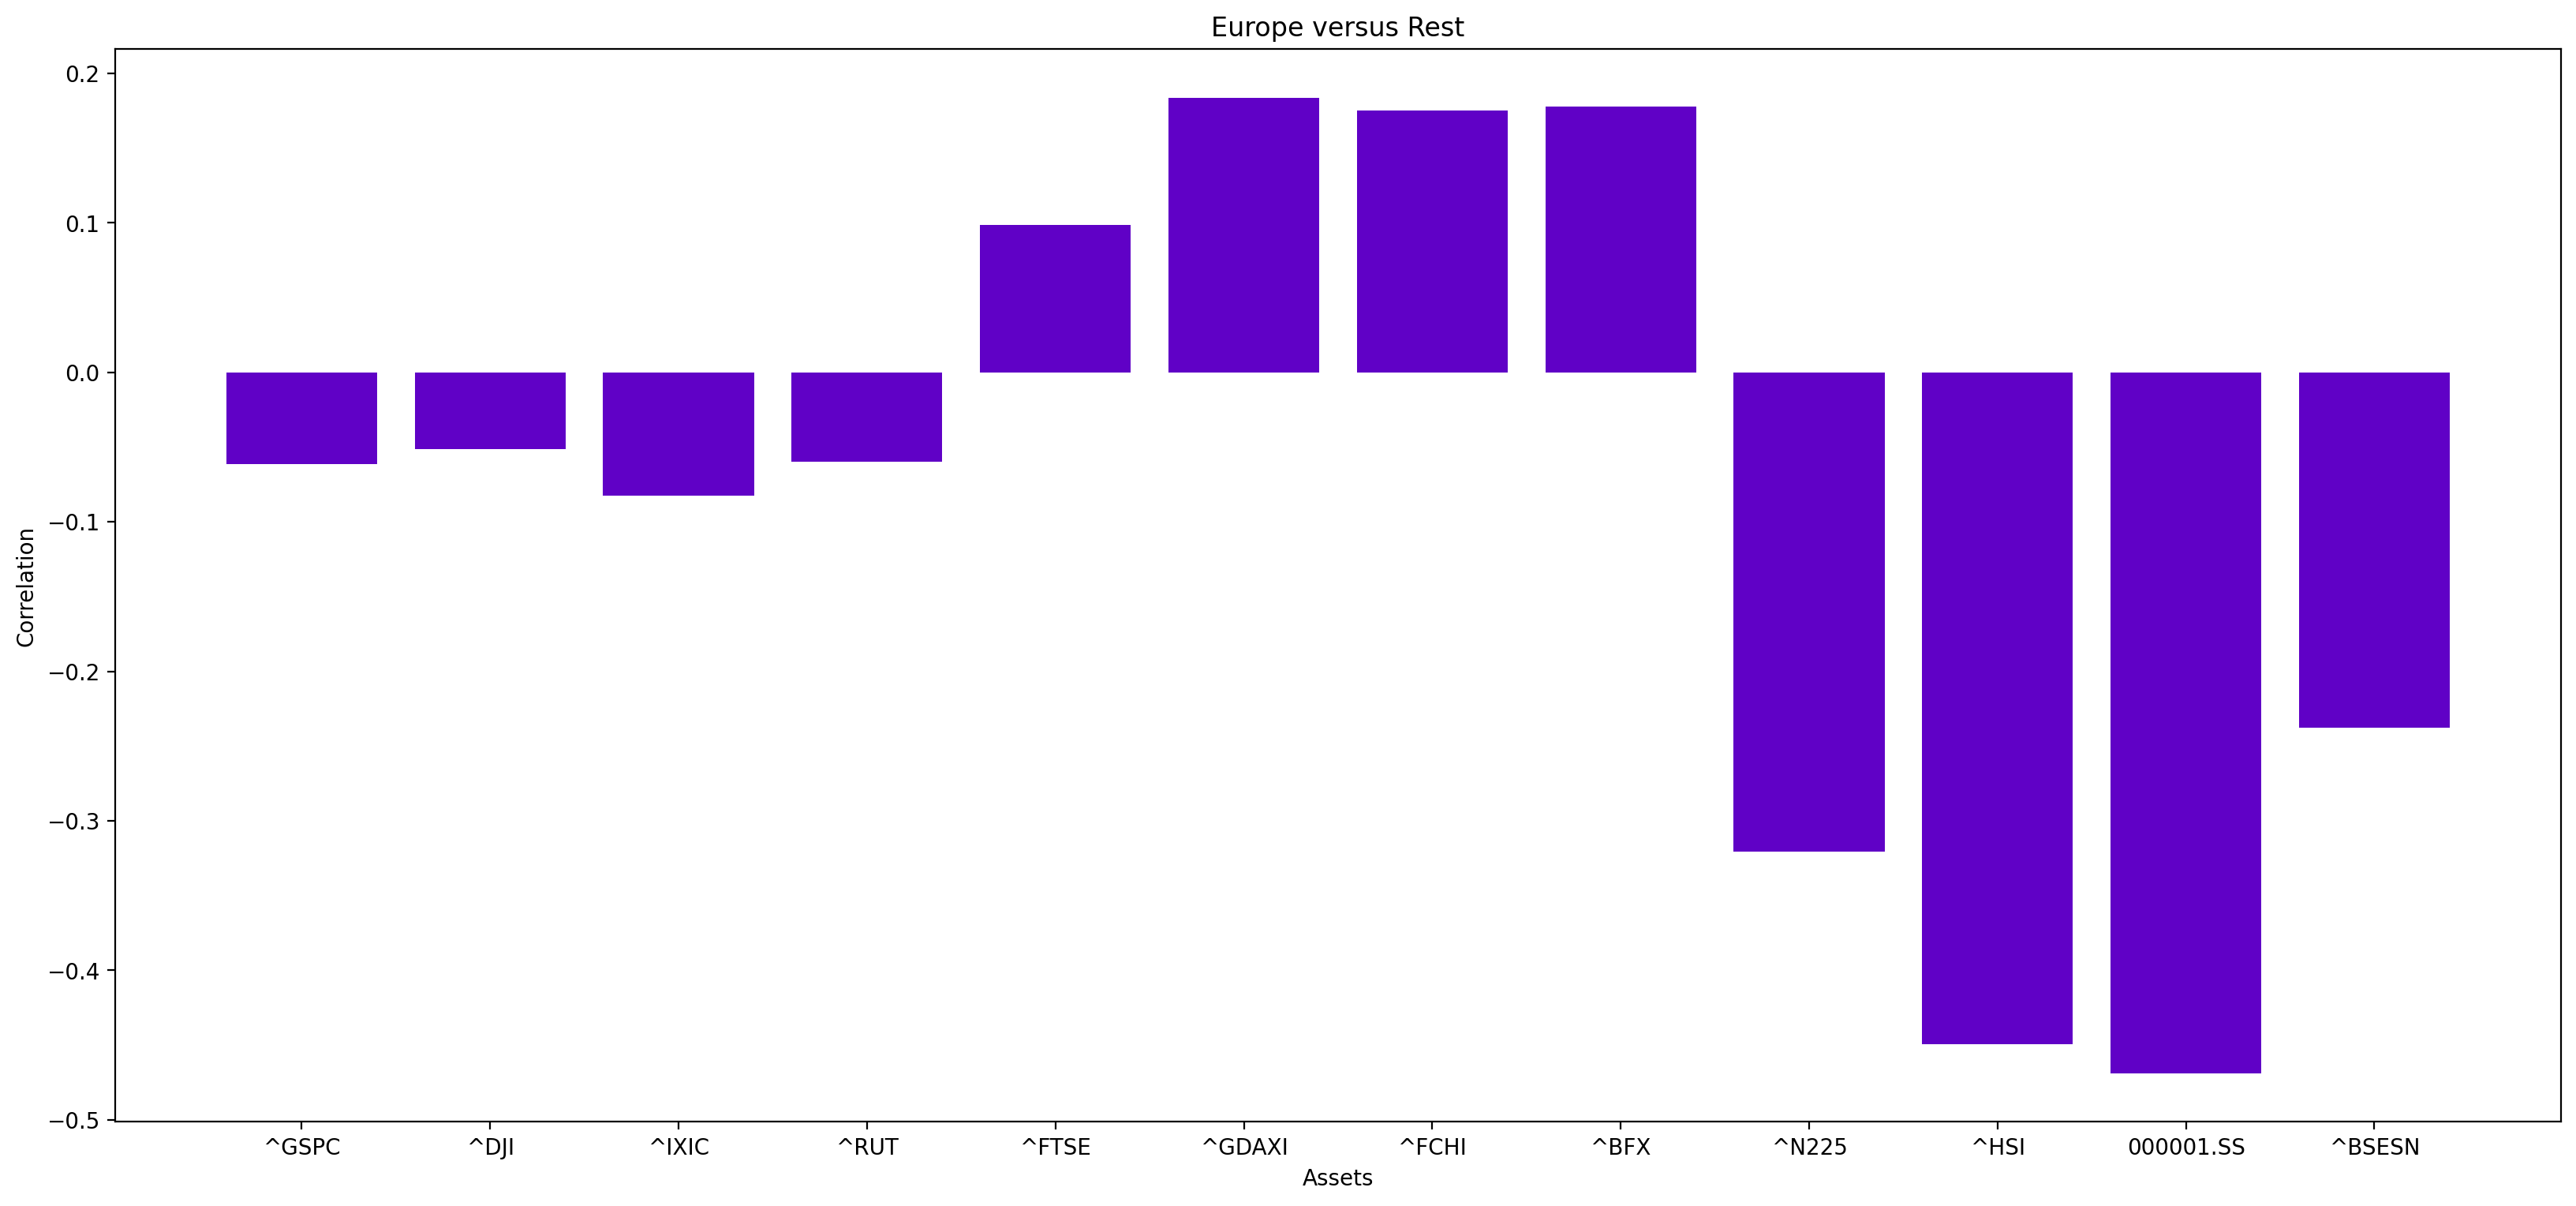

In [9]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis().fit(StandardScaler().fit_transform(dataset))

component_labels = {
    0: f'Global Market',
    1: f'US versus Rest',
    2: f'Europe versus Rest',
}

for n, component in enumerate(fa.components_):
    if n in component_labels:
        plt.bar(dataset.columns, component)
        plt.xlabel('Assets')
        plt.ylabel('Correlation')
        plt.title(component_labels[n])
        plt.show()

Indeed we see a similar result as with PCA. A first difference we can notice is in the second component; whereas in the second component Europe barely correlates, in the second factor it does.

Another notable difference is the fact that FA is not able to detect more than three underlying factors.

In [10]:
(fa.components_.sum(axis=1) != 0).sum()

3

# Copulas

To find out which asset pairs fit to which copula family the best, we try to fit every possible pair to every possible family and create a heatmap of the *log-likelihood*. The higher this number, the better the pair's distributions match.

In [11]:
from itertools import combinations

# https://github.com/vinecopulib/pyvinecopulib
import pyvinecopulib as pv

# pyvinecopulib is great but expects data to be pseudo-observations
# borrowing computer from from https://github.com/DanielBok/copulae
from copulae.core import pseudo_obs

results = []
for pair in list(combinations(dataset.columns, 2)):

    data = pseudo_obs(dataset[[pair[0], pair[1]]])

    family_set=[
        pv.BicopFamily.gaussian,
        pv.BicopFamily.student,
        pv.BicopFamily.clayton,
        pv.BicopFamily.gumbel,
        pv.BicopFamily.frank
    ]

    pair_results = {'pair': pair}
    for family in family_set:
        copula = pv.Bicop(family=family)
        copula.fit(data)
        pair_results[family.name.capitalize()] = copula.loglik()
    results.append(pair_results)
    
results = pd.DataFrame(results).set_index('pair')

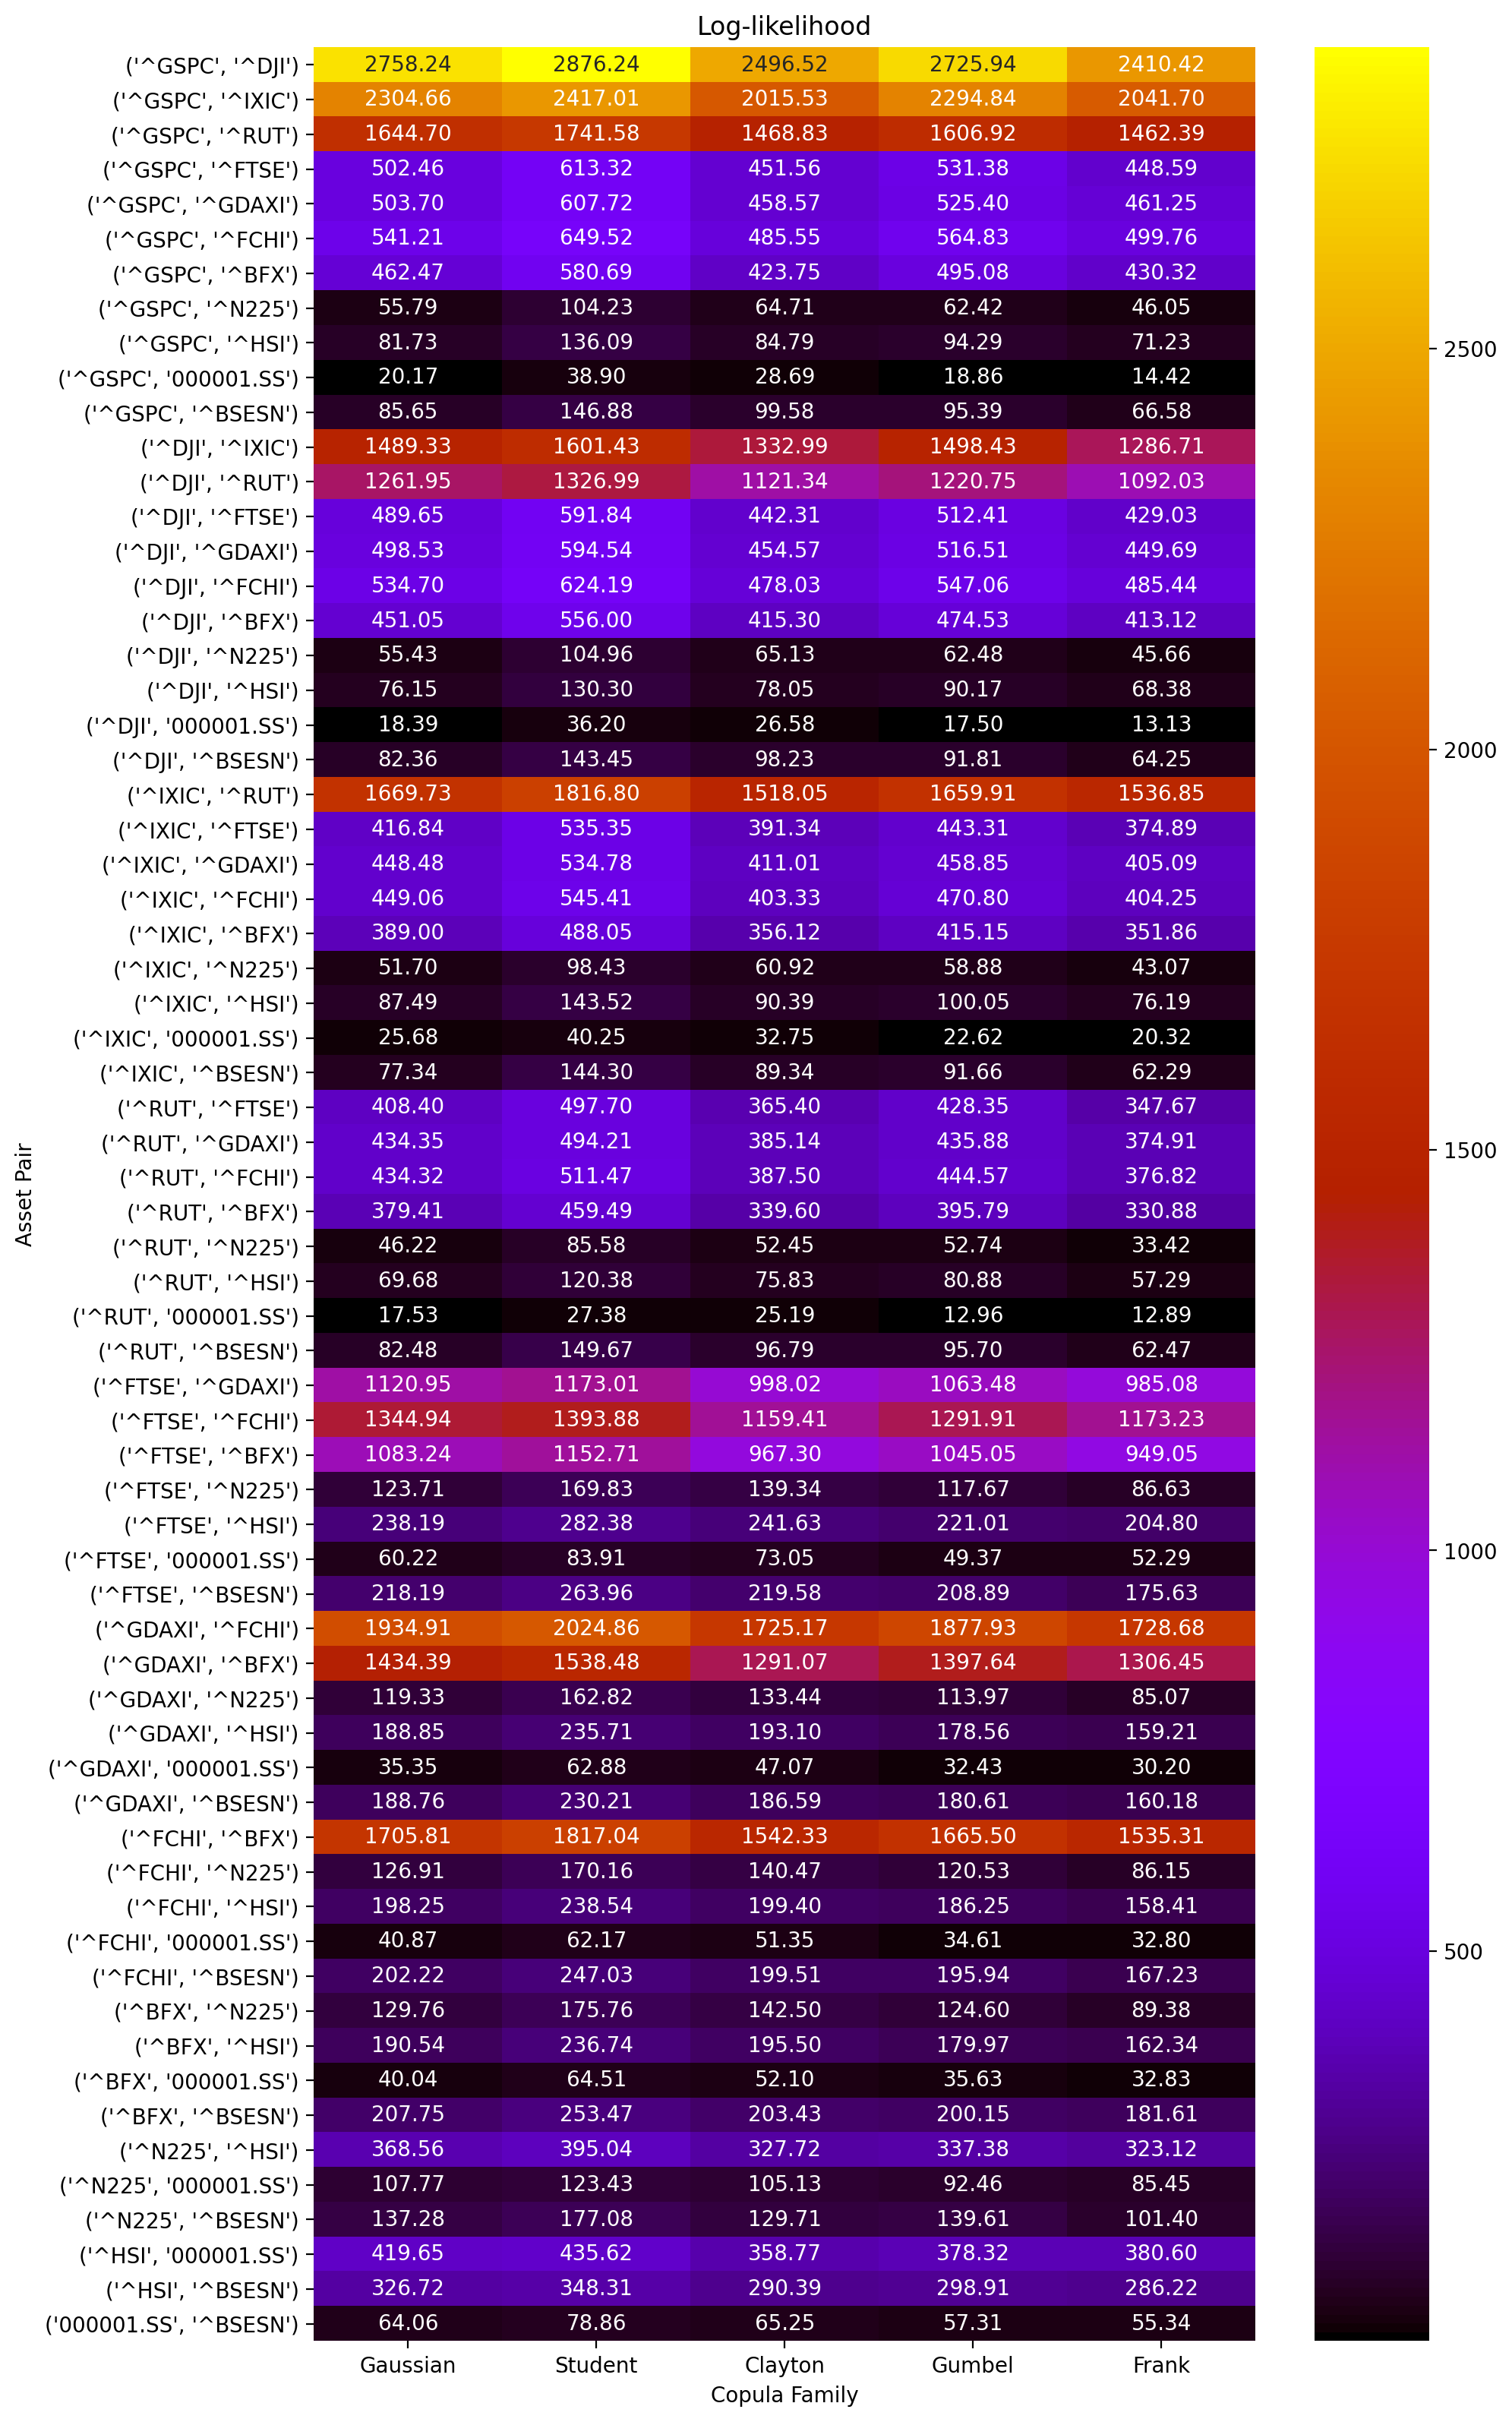

In [12]:
plt.figure(figsize=(10,20))
sns.heatmap(results, annot=True, fmt='.2f', cmap='gnuplot')
plt.title('Log-likelihood')
plt.xlabel('Copula Family')
plt.ylabel('Asset Pair')
plt.show()

In [13]:
results.idxmax(axis=1).value_counts()

Student    66
dtype: int64

We can observe a couple of interesting things. First, the Student's t-distribution copula provides the highest log-likelihood in all 66 cases. Second, we see that certain pairs have a noteably high log-likelihood across all copula families. In all cases these are pairs belonging to the same continent. Lastly it is surprising to see that this phenomenon is much weaker for the Asian indices.

Let's compare the copulas of the best and worst matching pairs.

In [14]:
def z_pdf(copula, x1, x2, zclip=30):
    """computes third dimension using pdf of fitted copula
    inspired by https://github.com/blent-ai/pycopula/blob/master/pycopula/visualization.py"""
    
    x1 = np.sort(x1)
    x2 = np.sort(x2)
    z= []
    for i in range(len(x1)):
        row = []
        for j in range(len(x2)):
            row.append(min(copula.pdf([[x1[i], x2[j] ]])[0], zclip))
        z.append(row)

    return x1, x2, np.asarray(z)

best_pair = results.max(axis=1).idxmax()
best_data = pseudo_obs(dataset[[best_pair[0], best_pair[1]]])

best_copula = pv.Bicop(family=pv.BicopFamily.student)
best_copula.fit(best_data)

x1, x2 = best_data[:, 0], best_data[:, 1]
x1_s, x2_s, z = z_pdf(best_copula, x1, x2)
x, y = np.meshgrid(x1_s, x2_s)

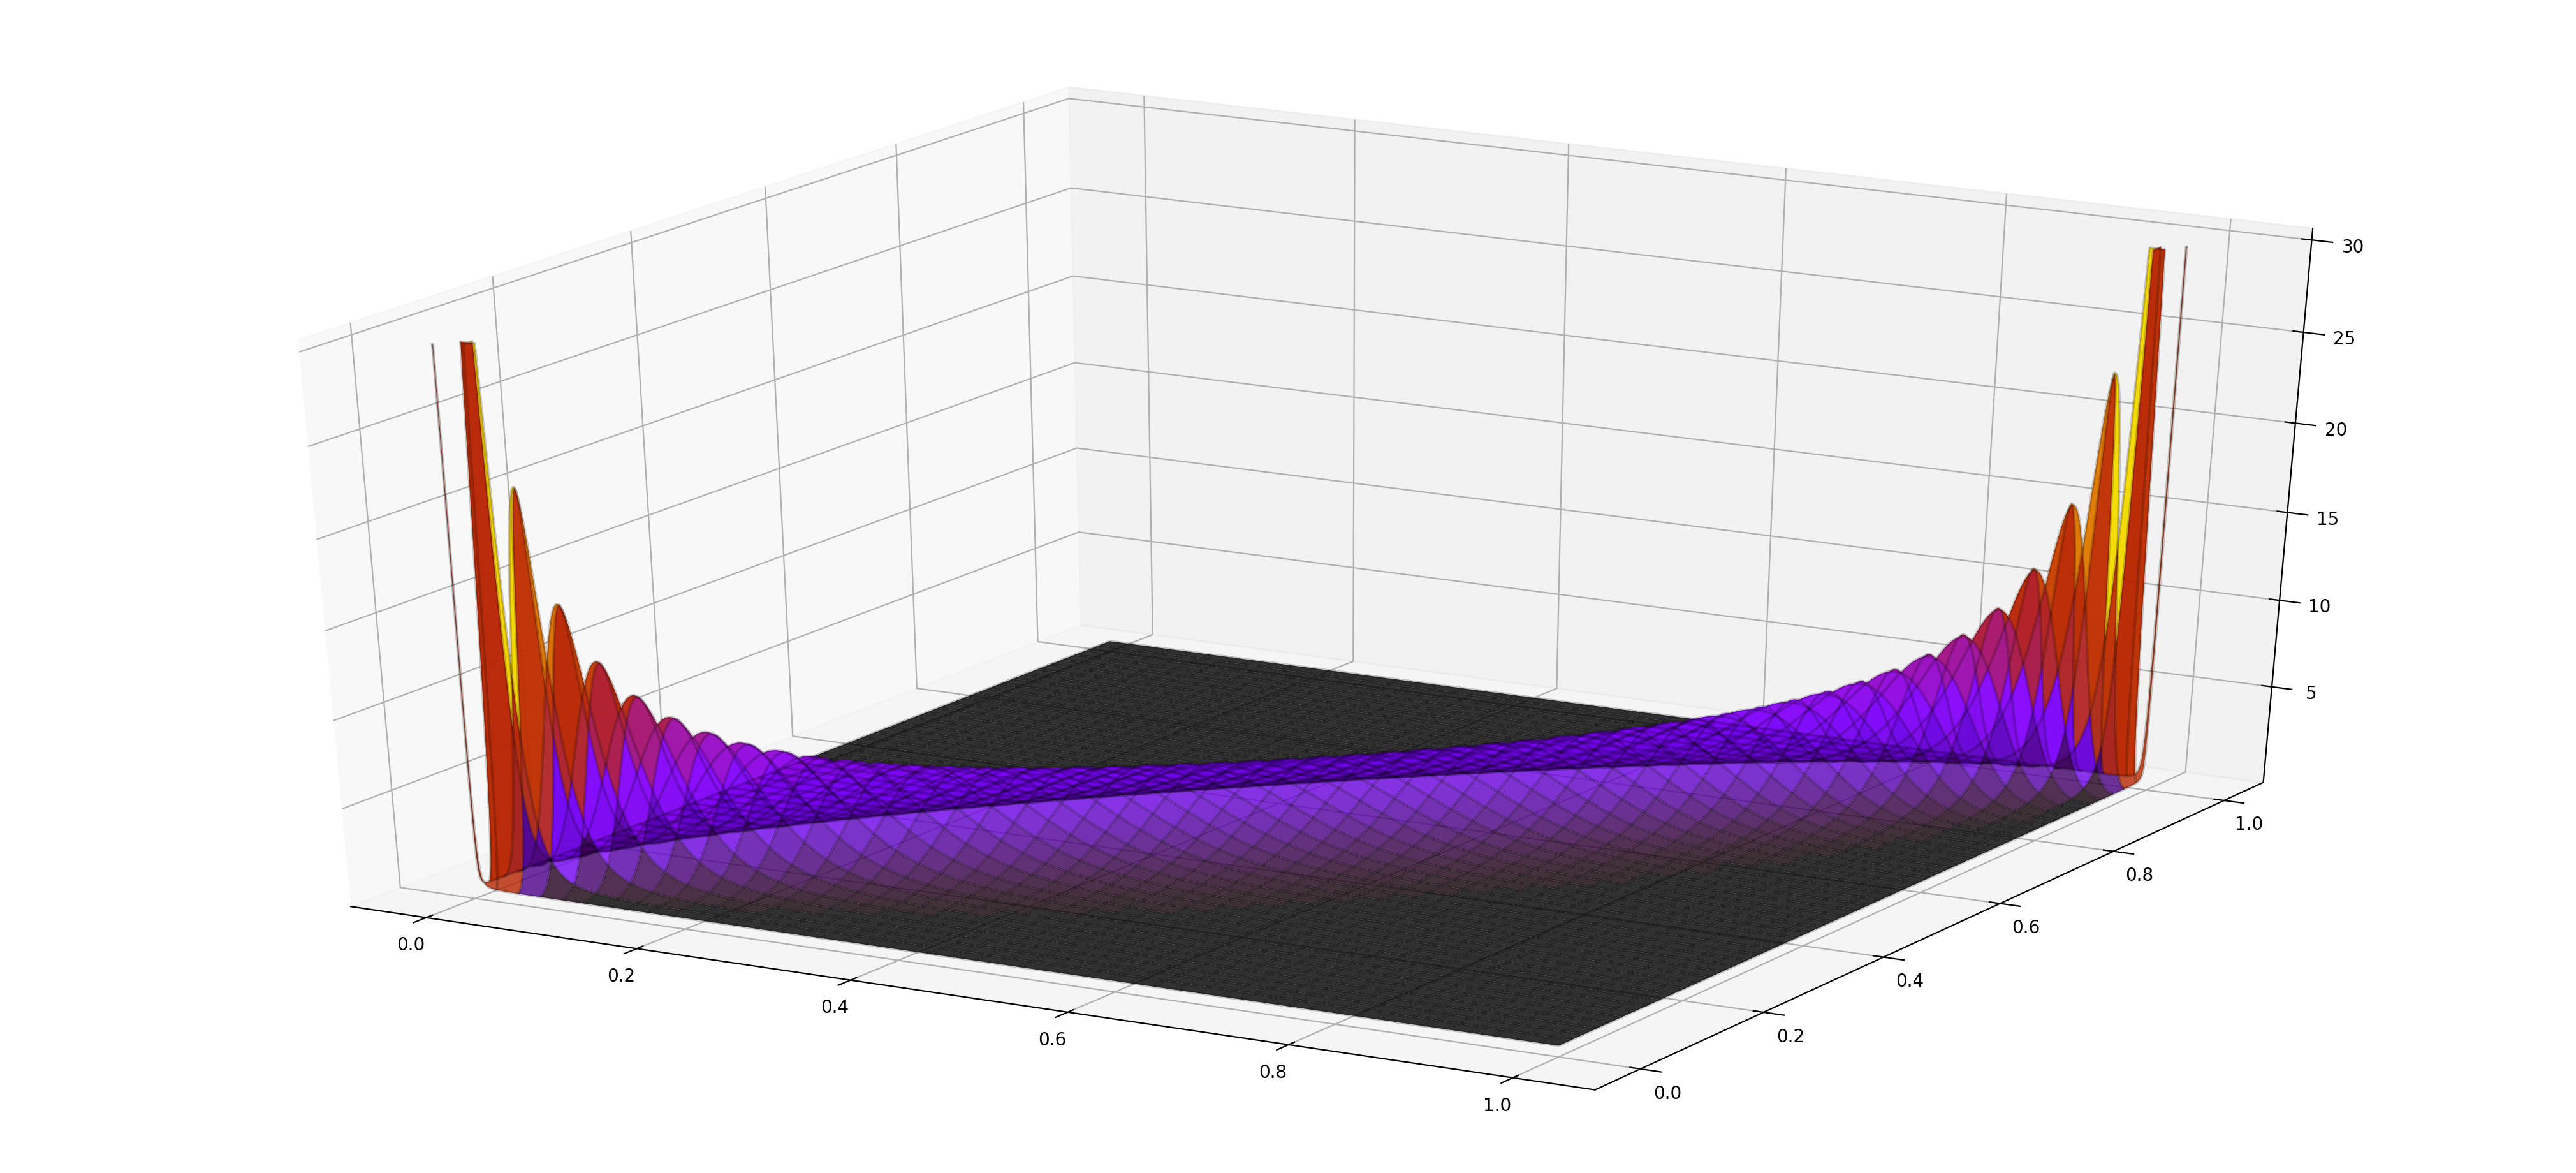

In [15]:
from mpl_toolkits.mplot3d import Axes3D

ax = Axes3D(plt.figure())
ax.plot_surface(x, y, z, alpha=.8, cmap='gnuplot')
ax.plot_wireframe(x, y, z, color='black', alpha=.2)
plt.show()

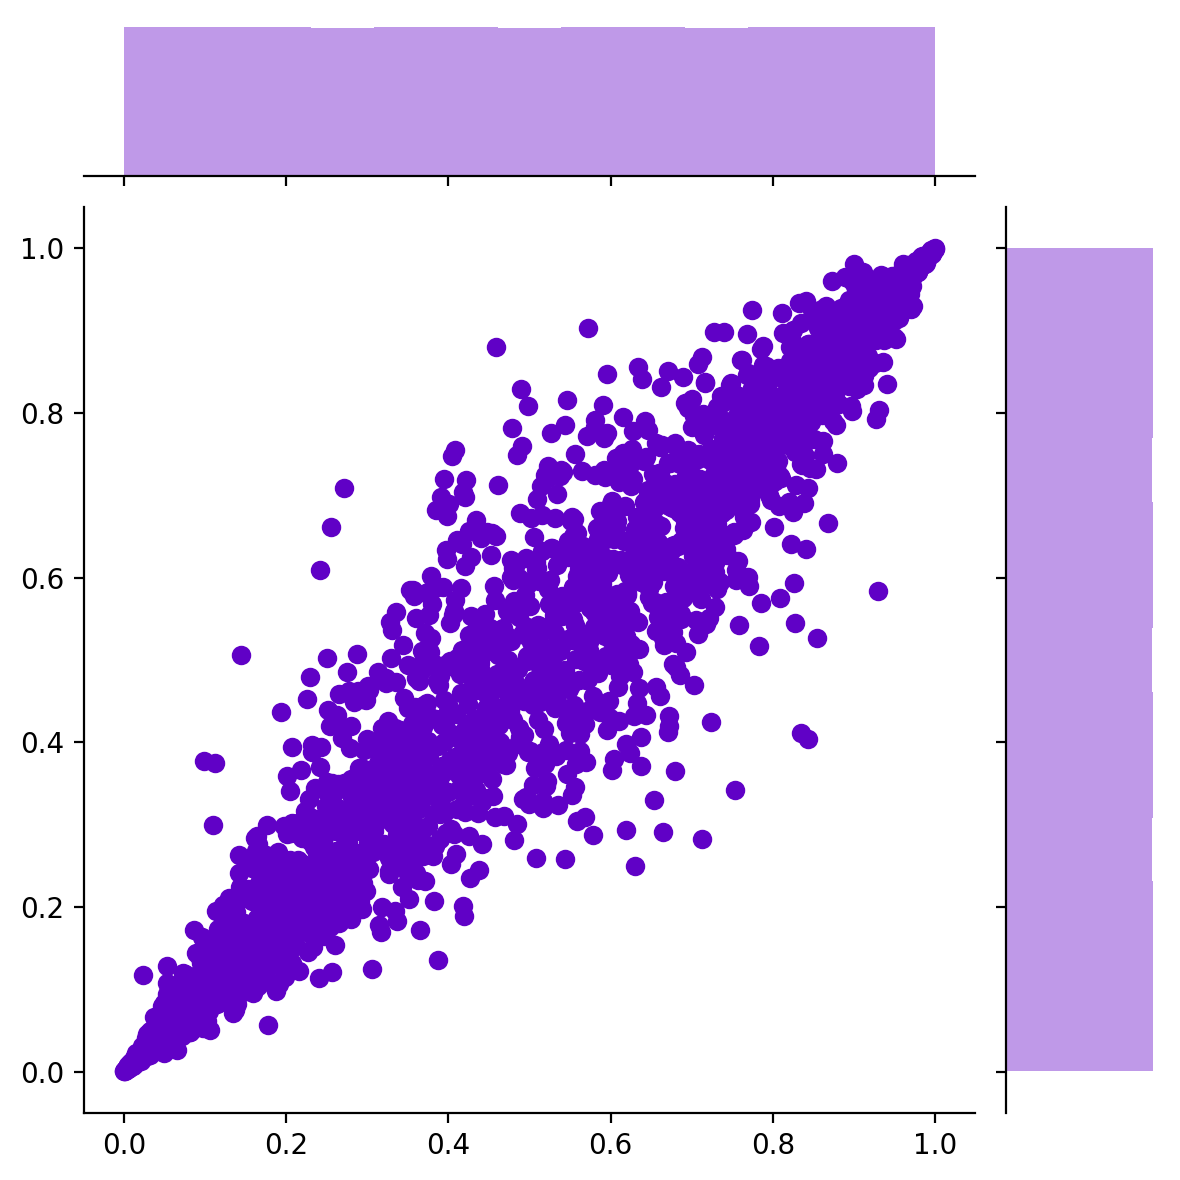

In [16]:
sns.jointplot(x1, x2, kind='scatter', cmap='gnuplot')
plt.show()